# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [175]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost

In [176]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn para treinamento da rede neural
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# 1. Coleta de dados

Dataset de https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [177]:
import os

if not os.path.exists('./data/student-dropout.zip'):
    !curl -L -o ./data/student-dropout.zip 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/higher-education-predictors-of-student-retention'
    !unzip ./data/student-dropout.zip -d ./data
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [178]:
data = pd.read_csv("./data/dataset.csv")

# 2. Análise Exploratória dos Dados

O objetivo é entender melhor e sumarizar as características dos dados, analisando quantidade e tipos de atributos, verificando distribuição do atributo alvo, identificando padrões e anomalias, removendo atributos que pareçam irrelevantes ou problemáticos, etc. Utilize gráficos e sumarizações estatísticas para a EDA. Verifique potenciais problemas nos dados, como por exemplo, a necessidade de normalizar os atributos, balancear classes, ou remover instâncias ou atributos por inconsistências nos dados.

Objetivo: compreender como as variáveis do dataset se relacionam com a probabilidade de desistência da universidade.

- P1. Qual a quantidade e tipos de atributos? Existem inconsistências?
  - Quais são os atributos disponíveis? Dentre eles, quais são os categóricos, e quais são os numéricos?
  - Existem inconsistências nos atributos? (Atributos vazios, potenciais erros, etc)
  - Existem atributos que necessitam ser removidos ou transformados?
- P2. Qual a distribuição do atributo alvo?
  - Quais são as classes alvo? Qual a distribuição entre as classes? Está balanceada ou desbalanceada?
- P3. Quais os padrões e anomalias dos atributos individuais?
  - Quais as relações entre as variávies numéricas e categóricas?
- P4. Quais os padrões e anomalias entre todos os atributos?
  - Qual o range dos atributos numéricos? Eles necessitam ser normalizados?




## P1. Qual a quantidade e tipos de atributos?

**Quantidade de atributos**

In [179]:
data.info(verbose = False, memory_usage = False, show_counts = True) # mostra o tipo e a quantidade de itens não nulos de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 35 entries, Marital status to Target
dtypes: float64(5), int64(29), object(1)

Existem 35 atributos, onde um é o atributo alvo ('Target') e os outros 34 são potenciais atributos treináveis.

In [180]:
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Tipos de atributos**

In [181]:
data.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
Age at enrollm

O atributo alvo é codificado como tipo object, o que significa um ponteiro que aponta para strings. 

Os 34 atributos potencialmente treináveis estão codificados como atributos numéricos float64 ou int64. Todavia, pela descrição do conjunto de dados, alguns destes parâmetros são categóricos e foram codificados para int64.

Isto dificulta a interpreteação dos gráficos e análise entre atributos categóricos e numéricos. Para isto, reconstruímos os atributos categóricos em um novo DataFrame através das informações do data descriptor deste dataset [[1](https://doi.org/10.3390/data7110146)] 

Em primeiro lugar, separamos manualmente, com base no descritor, o nome dos atributos em duas listas.

In [182]:
categorical_data = ['Marital status', 'Application mode', 'Course', 'Daytime/evening attendance', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation", 'Displaced',
       'Educational special needs', 'Debtor', 'Tuition fees up to date',
       'Gender', 'Scholarship holder', 'Age at enrollment', 'International', 'Target']

numerical_data = ['Application order', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP']

Criamos um dicionário dos dados categóricos, a partir do descritor do conjunto de dados [1] e com auxílio do Github Copilot para acelerar a transcrição.

In [183]:
# Dicionário de dados

data_cat = data.copy(deep=True)

data_cat['Marital status'] = data['Marital status'].map({
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
})

data_cat['Nacionality'] = data['Nacionality'].map({
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldova (Republic of)',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
})

data_cat['Application mode'] = data['Application mode'].map({
    1: '1st phase—general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase—special contingent (Azores Island)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase—special contingent (Madeira Island)',
    8: '2nd phase—general contingent',
    9: '3rd phase—general contingent',
    10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change in course',
    15: 'Technological specialization diploma holders',
    16: 'Change in institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change in institution/course (International)'
})

data_cat['Course'] = data['Course'].map({
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equiniculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
})

data_cat['Previous qualification'] = data['Previous qualification'].map({
    1: 'Secondary education',
    2: 'Higher education—bachelor’s degree',
    3: 'Higher education—degree',
    4: 'Higher education—master’s degree',
    5: 'Higher education—doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling—not completed',
    8: '11th year of schooling—not completed',
    9: 'Other—11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling—not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equivalent',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equivalent',
    14: 'Technological specialization course',
    15: 'Higher education—degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education—master’s degree (2nd cycle)'
})

parents_qualification_mapping = {
    1: 'Secondary Education—12th Year of Schooling or Equivalent',
    2: 'Higher Education—bachelor’s degree',
    3: 'Higher Education—degree',
    4: 'Higher Education—master’s degree',
    5: 'Higher Education—doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling—not completed',
    8: '11th Year of Schooling—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year of Schooling',
    11: '2nd year complementary high school course',
    12: '10th Year of Schooling',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    15: 'Complementary High School Course',
    16: 'Technical-professional course',
    17: 'Complementary High School Course—not concluded',
    18: '7th year of schooling',
    19: '2nd cycle of the general high school course',
    20: '9th Year of Schooling—not completed',
    21: '8th year of schooling',
    22: 'General Course of Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without having a 4th year of schooling',
    27: 'Basic education 1st cycle (4th/5th year) or equivalent',
    28: 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies course',
    32: 'Professional higher technical course',
    33: 'Higher Education—master’s degree (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
}

data_cat["Mother's qualification"] = data["Mother's qualification"].map(parents_qualification_mapping)
data_cat["Father's qualification"] = data["Father's qualification"].map(parents_qualification_mapping)

parents_occupation_mapping = {
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers, and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry',
    8: 'Skilled Workers in Industry, Construction, and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: '(blank)',
    14: 'Armed Forces Officers',
    15: 'Armed Forces Sergeants',
    16: 'Other Armed Forces personnel',
    17: 'Directors of administrative and commercial services',
    18: 'Hotel, catering, trade, and other services directors',
    19: 'Specialists in the physical sciences, mathematics, engineering, and related techniques',
    20: 'Health professionals',
    21: 'Teachers',
    22: 'Specialists in finance, accounting, administrative organization, and public and commercial relations',
    23: 'Intermediate level science and engineering technicians and professions',
    24: 'Technicians and professionals of intermediate level of health',
    25: 'Intermediate level technicians from legal, social, sports, cultural, and similar services',
    26: 'Information and communication technology technicians',
    27: 'Office workers, secretaries in general, and data processing operators',
    28: 'Data, accounting, statistical, financial services, and registry-related operators',
    29: 'Other administrative support staff',
    30: 'Personal service workers',
    31: 'Sellers',
    32: 'Personal care workers and the like',
    33: 'Protection and security services personnel',
    34: 'Market-oriented farmers and skilled agricultural and animal production workers',
    35: 'Farmers, livestock keepers, fishermen, hunters and gatherers, and subsistence',
    36: 'Skilled construction workers and the like, except electricians',
    37: 'Skilled workers in metallurgy, metalworking, and similar',
    38: 'Skilled workers in electricity and electronics',
    39: 'Workers in food processing, woodworking, and clothing and other industries and crafts',
    40: 'Fixed plant and machine operators',
    41: 'Assembly workers',
    42: 'Vehicle drivers and mobile equipment operators',
    43: 'Unskilled workers in agriculture, animal production, and fisheries and forestry',
    44: 'Unskilled workers in extractive industry, construction, manufacturing, and transport',
    45: 'Meal preparation assistants',
    46: 'Street vendors (except food) and street service providers'
}

data_cat["Mother's occupation"] = data["Mother's occupation"].map(parents_occupation_mapping)
data_cat["Father's occupation"] = data["Father's occupation"].map(parents_occupation_mapping)

data_cat['Gender'] = data['Gender'].map({
    1: 'male',
    0: 'female'
})

data_cat['Daytime/evening attendance'] = data['Daytime/evening attendance'].map({
    1: 'daytime',
    0: 'evening'
})

binary_mapping = {
    'Displaced': {1: 'yes', 0: 'no'},
    'Educational special needs': {1: 'yes', 0: 'no'},
    'Debtor': {1: 'yes', 0: 'no'},
    'Tuition fees up to date': {1: 'yes', 0: 'no'},
    'Scholarship holder': {1: 'yes', 0: 'no'},
    'International': {1: 'yes', 0: 'no'}
}

for column, mapping in binary_mapping.items():
    data_cat[f'{column}'] = data[column].map(mapping)

data_cat['Target'] = data['Target'].copy()

In [184]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   object 
 1   Application mode                                4424 non-null   object 
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   object 
 4   Daytime/evening attendance                      4424 non-null   object 
 5   Previous qualification                          4424 non-null   object 
 6   Nacionality                                     4424 non-null   object 
 7   Mother's qualification                          4424 non-null   object 
 8   Father's qualification                          4424 non-null   object 
 9   Mother's occupation                      

**Quantidade de atributos categóricos e numéricos**

In [185]:
# Contar a quantidade de atributos categóricos e numéricos
num_categorical = len(data_cat.select_dtypes(include=['object']).columns)
num_numerical = len(data_cat.select_dtypes(include=['number']).columns)

print(f"Quantidade de atributos categóricos: {num_categorical}")
print(f"Quantidade de atributos numéricos: {num_numerical}")

Quantidade de atributos categóricos: 18
Quantidade de atributos numéricos: 17


## P2. Qual a distribuição do atributo alvo?

In [186]:
print(data["Target"].unique())

['Dropout' 'Graduate' 'Enrolled']


In [187]:
data['Target'].describe(include='all')

count         4424
unique           3
top       Graduate
freq          2209
Name: Target, dtype: object

Percentual de frequência das classes do atributo alvo

In [188]:
series = data['Target'].value_counts(normalize=True)
print(series)


Target
Graduate    0.499322
Dropout     0.321203
Enrolled    0.179476
Name: proportion, dtype: float64


In [189]:
# Diferença entre a classe mais frequente e a menos frequente
print(series['Graduate'] - series['Enrolled'])

0.3198462929475588


<Axes: xlabel='Target', ylabel='count'>

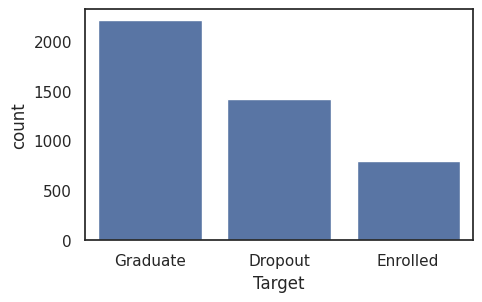

In [190]:
fig = plt.figure(figsize=(5, 3))

sns.countplot(x = data['Target'], data = data, 
                order=data['Target'].value_counts().index)

Existe um **desbalanceamento nas classes do atributo alvo**. A classe 'Graduate', que representa os estudantes formados, tem 31,9% mais instâncias do que 'Enrolled', que representa os estudantes com o curso em andamento.

**Possibilidade de ação**: escolher um método de amostragem para balancear as classes do atributo alvo.

## P3. Quais os padrões e anomalias dos atributos individuais?

### Atributos numéricos - univariados

Gráficos
- Histograma: distribuição de frequência
- Boxplot

Estatísticas descritivas univariadas
- Média (sensível a outliers)
- Mediana (menos sensível a outliers)
- Desvio padrão
- Mínimo e máximo
- Intervalo
- Quartil (Q1, Q2, Intervalo Interquartil, Limites Superior e Inferior)
- Assimetria
- Curtose
- Dados vazios

Application order

Média : 1.73
Mediana : 1.0
Variância : 1.73
Desvio padrão : 1.31
Min : 0
Max : 9
Intervalo:  9
Amostras únicas : 8
Amostras faltando : 0
Q1 : 1.0
Q3 : 2.0
IQR : 1.0
Limite inferior : -0.5
Limite superior : 3.5
Obliquidade : 1.88
Curtose : 2.65


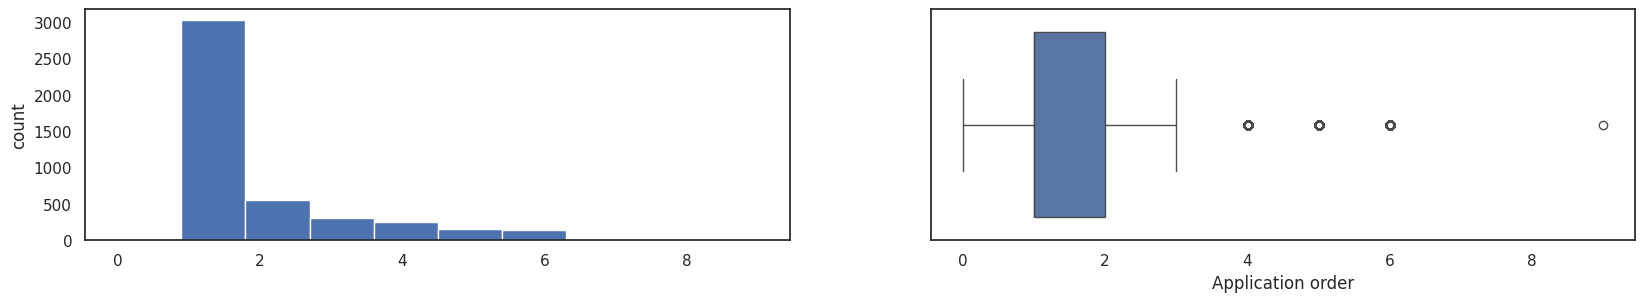

Curricular units 1st sem (credited)

Média : 0.71
Mediana : 0.0
Variância : 5.57
Desvio padrão : 2.36
Min : 0
Max : 20
Intervalo:  20
Amostras únicas : 21
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 4.17
Curtose : 19.21


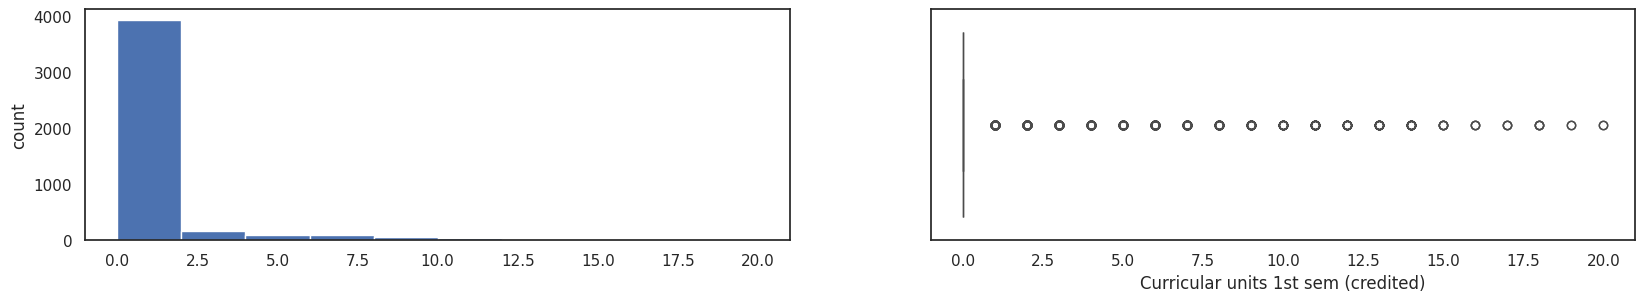

Curricular units 1st sem (enrolled)

Média : 6.27
Mediana : 6.0
Variância : 6.15
Desvio padrão : 2.48
Min : 0
Max : 26
Intervalo:  26
Amostras únicas : 23
Amostras faltando : 0
Q1 : 5.0
Q3 : 7.0
IQR : 2.0
Limite inferior : 2.0
Limite superior : 10.0
Obliquidade : 1.62
Curtose : 8.94


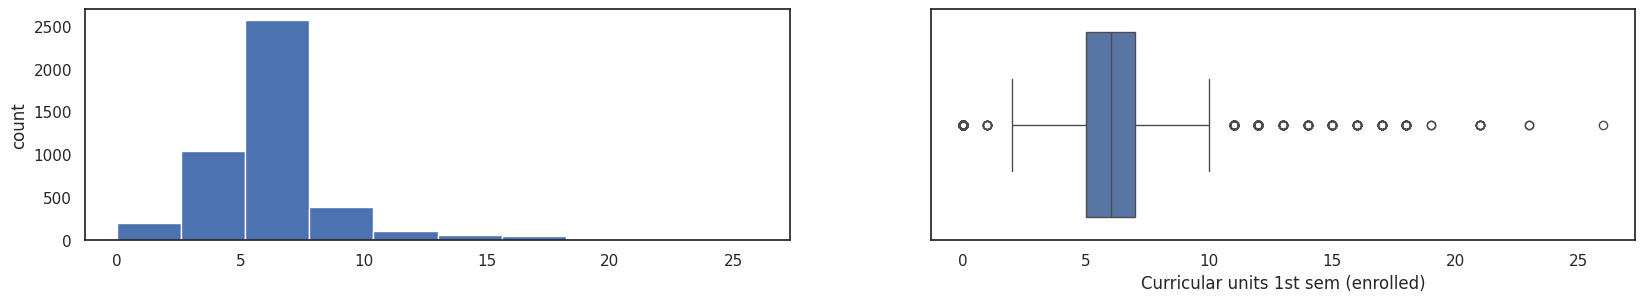

Curricular units 1st sem (evaluations)

Média : 8.3
Mediana : 8.0
Variância : 17.46
Desvio padrão : 4.18
Min : 0
Max : 45
Intervalo:  45
Amostras únicas : 35
Amostras faltando : 0
Q1 : 6.0
Q3 : 10.0
IQR : 4.0
Limite inferior : 0.0
Limite superior : 16.0
Obliquidade : 0.98
Curtose : 5.46


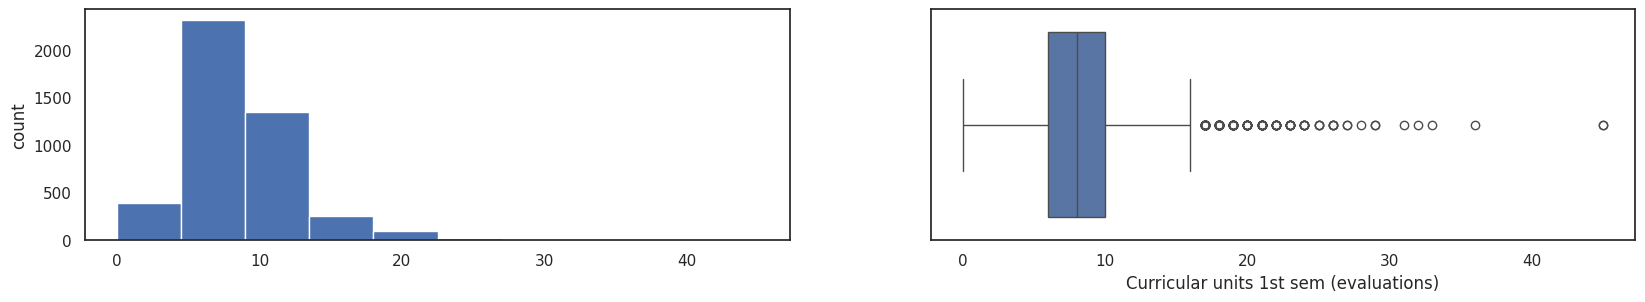

Curricular units 1st sem (approved)

Média : 4.71
Mediana : 5.0
Variância : 9.57
Desvio padrão : 3.09
Min : 0
Max : 26
Intervalo:  26
Amostras únicas : 23
Amostras faltando : 0
Q1 : 3.0
Q3 : 6.0
IQR : 3.0
Limite inferior : -1.5
Limite superior : 10.5
Obliquidade : 0.77
Curtose : 3.1


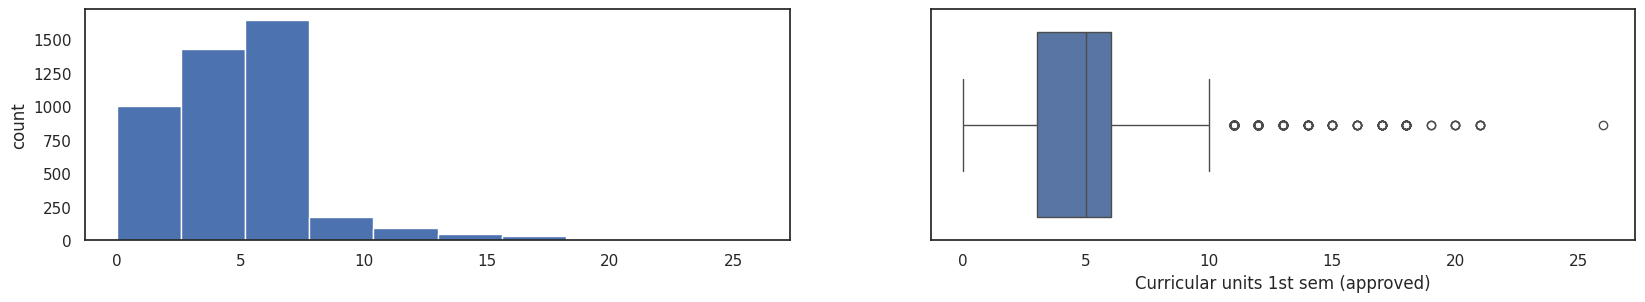

Curricular units 1st sem (grade)

Média : 10.64
Mediana : 12.29
Variância : 23.46
Desvio padrão : 4.84
Min : 0.0
Max : 18.88
Intervalo:  18.88
Amostras únicas : 805
Amostras faltando : 0
Q1 : 11.0
Q3 : 13.4
IQR : 2.4
Limite inferior : 7.4
Limite superior : 17.0
Obliquidade : -1.57
Curtose : 0.91


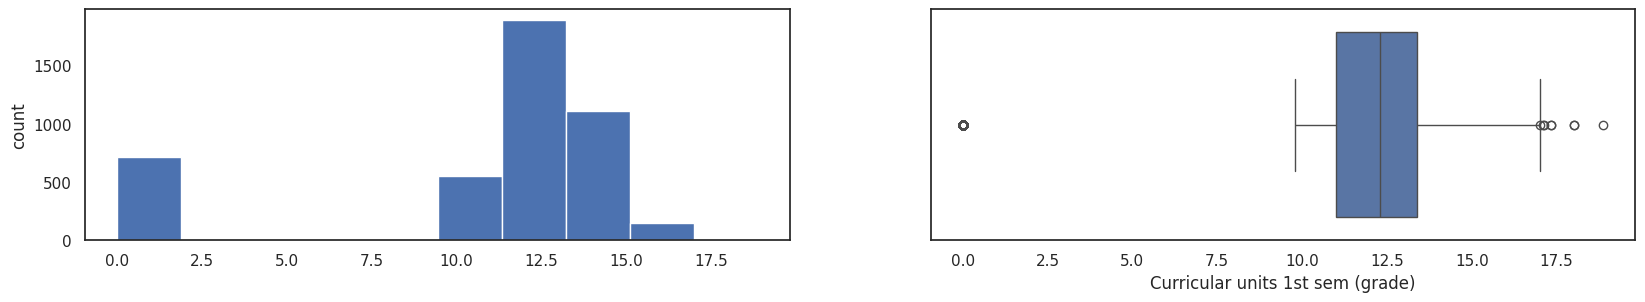

Curricular units 1st sem (without evaluations)

Média : 0.14
Mediana : 0.0
Variância : 0.48
Desvio padrão : 0.69
Min : 0
Max : 12
Intervalo:  12
Amostras únicas : 11
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 8.21
Curtose : 89.86


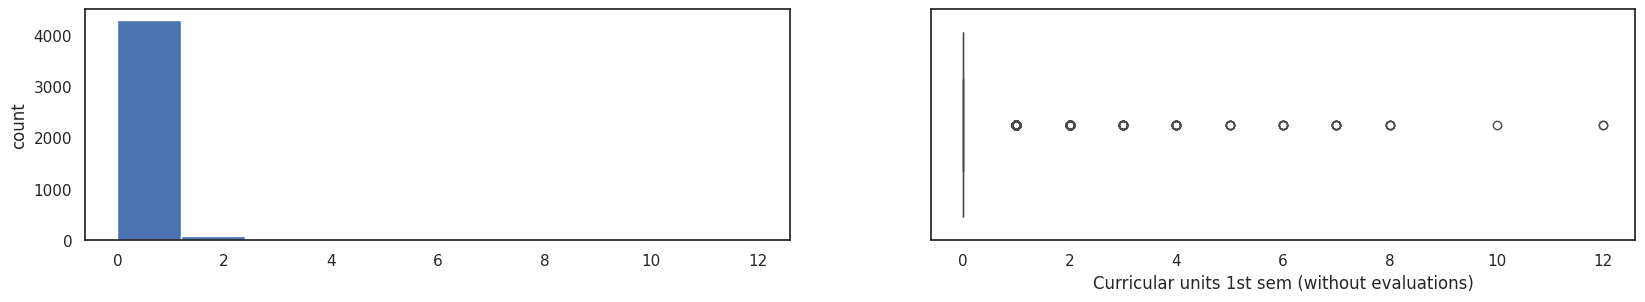

Curricular units 2nd sem (credited)

Média : 0.54
Mediana : 0.0
Variância : 3.68
Desvio padrão : 1.92
Min : 0
Max : 19
Intervalo:  19
Amostras únicas : 19
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 4.63
Curtose : 24.43


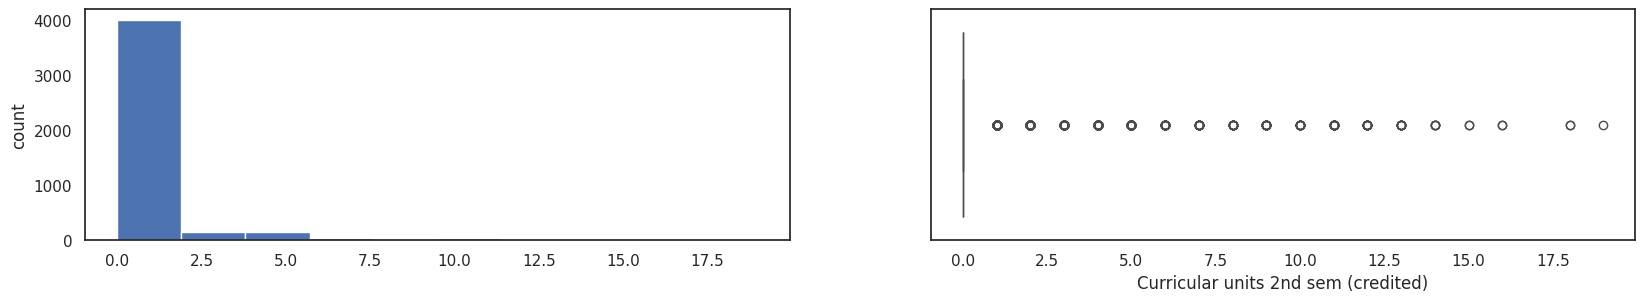

Curricular units 2nd sem (enrolled)

Média : 6.23
Mediana : 6.0
Variância : 4.82
Desvio padrão : 2.2
Min : 0
Max : 23
Intervalo:  23
Amostras únicas : 22
Amostras faltando : 0
Q1 : 5.0
Q3 : 7.0
IQR : 2.0
Limite inferior : 2.0
Limite superior : 10.0
Obliquidade : 0.79
Curtose : 7.13


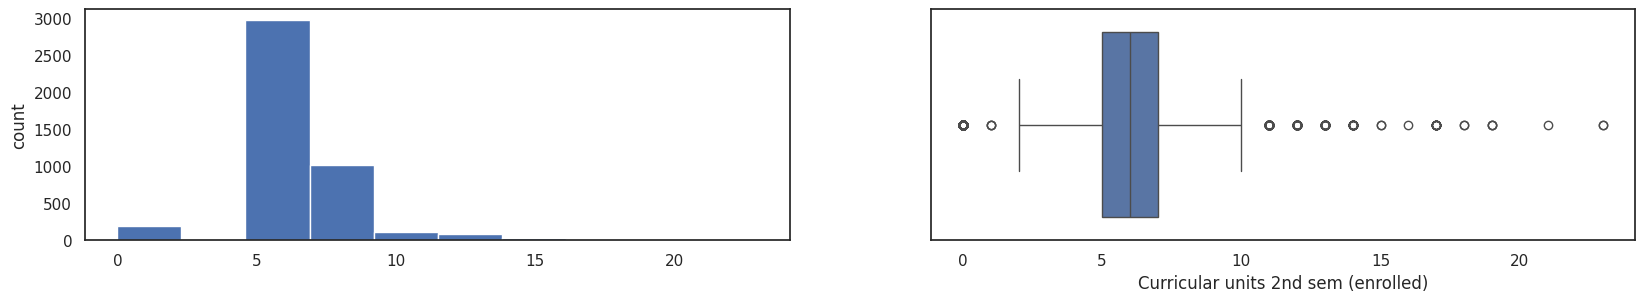

Curricular units 2nd sem (evaluations)

Média : 8.06
Mediana : 8.0
Variância : 15.59
Desvio padrão : 3.95
Min : 0
Max : 33
Intervalo:  33
Amostras únicas : 30
Amostras faltando : 0
Q1 : 6.0
Q3 : 10.0
IQR : 4.0
Limite inferior : 0.0
Limite superior : 16.0
Obliquidade : 0.34
Curtose : 2.07


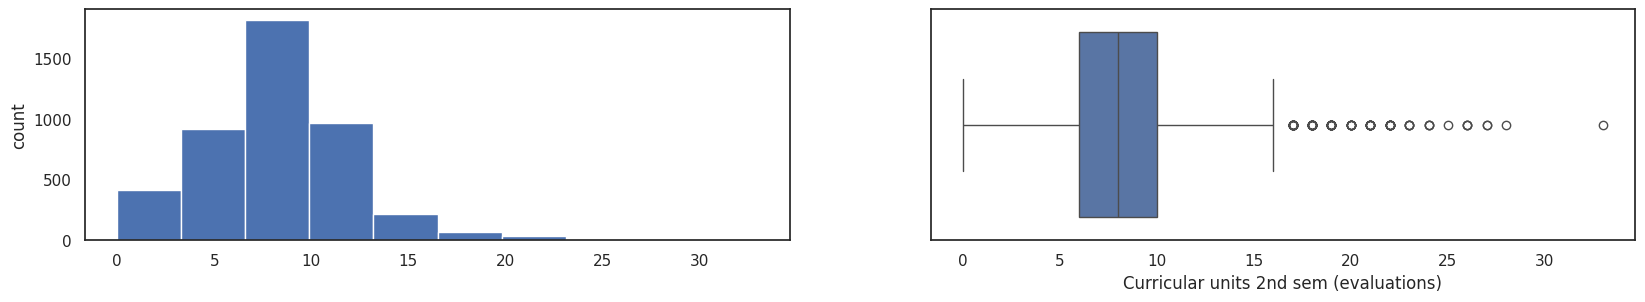

Curricular units 2nd sem (approved)

Média : 4.44
Mediana : 5.0
Variância : 9.09
Desvio padrão : 3.01
Min : 0
Max : 20
Intervalo:  20
Amostras únicas : 20
Amostras faltando : 0
Q1 : 2.0
Q3 : 6.0
IQR : 4.0
Limite inferior : -4.0
Limite superior : 12.0
Obliquidade : 0.31
Curtose : 0.85


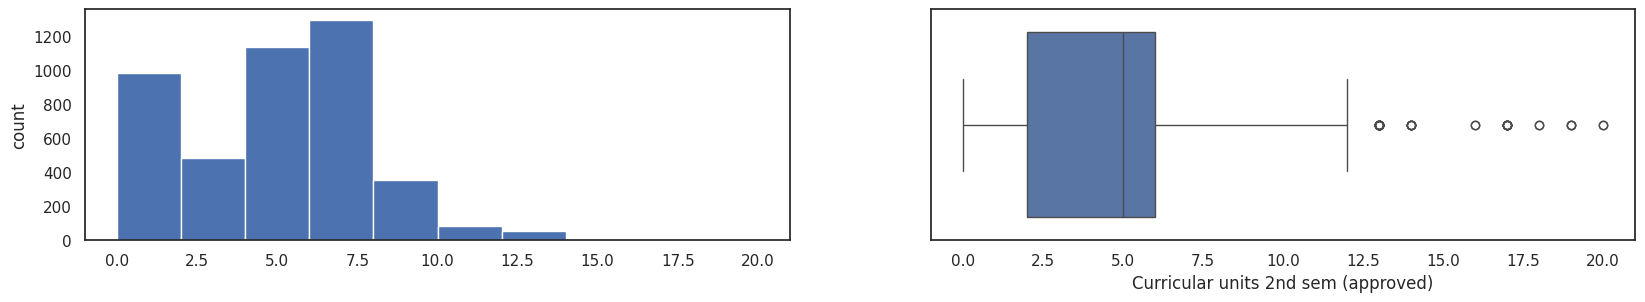

Curricular units 2nd sem (grade)

Média : 10.23
Mediana : 12.2
Variância : 27.15
Desvio padrão : 5.21
Min : 0.0
Max : 18.57
Intervalo:  18.57
Amostras únicas : 786
Amostras faltando : 0
Q1 : 10.75
Q3 : 13.33
IQR : 2.58
Limite inferior : 6.87
Limite superior : 17.21
Obliquidade : -1.31
Curtose : 0.07


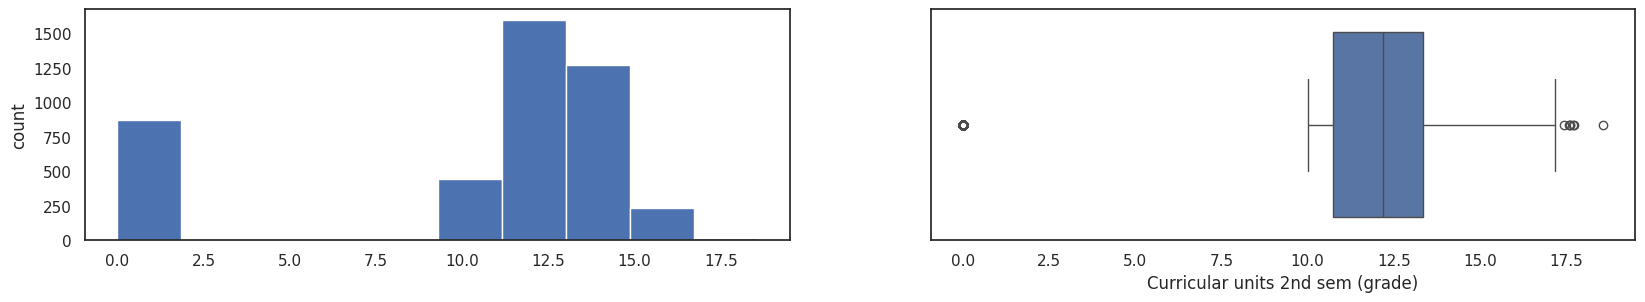

Curricular units 2nd sem (without evaluations)

Média : 0.15
Mediana : 0.0
Variância : 0.57
Desvio padrão : 0.75
Min : 0
Max : 12
Intervalo:  12
Amostras únicas : 10
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 7.27
Curtose : 66.81


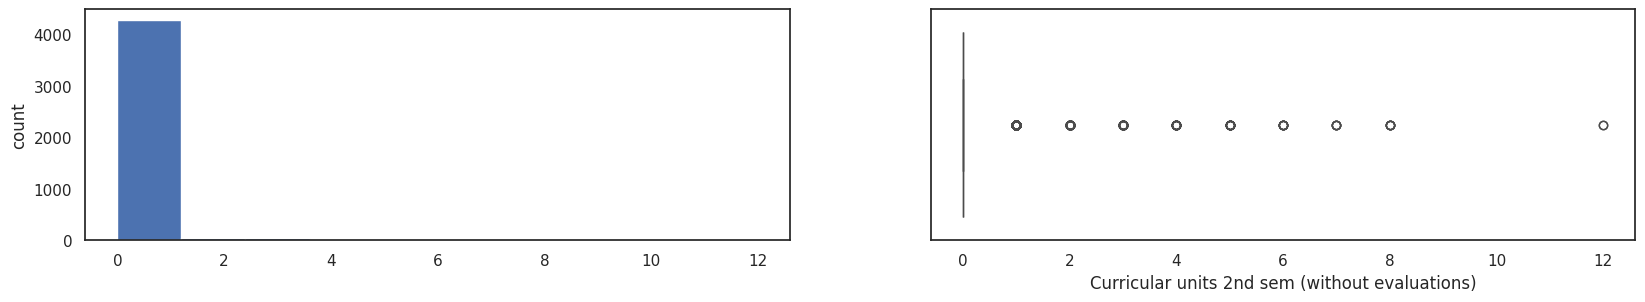

Unemployment rate

Média : 11.57
Mediana : 11.1
Variância : 7.1
Desvio padrão : 2.66
Min : 7.6
Max : 16.2
Intervalo:  8.6
Amostras únicas : 10
Amostras faltando : 0
Q1 : 9.4
Q3 : 13.9
IQR : 4.5
Limite inferior : 2.65
Limite superior : 20.65
Obliquidade : 0.21
Curtose : -1.0


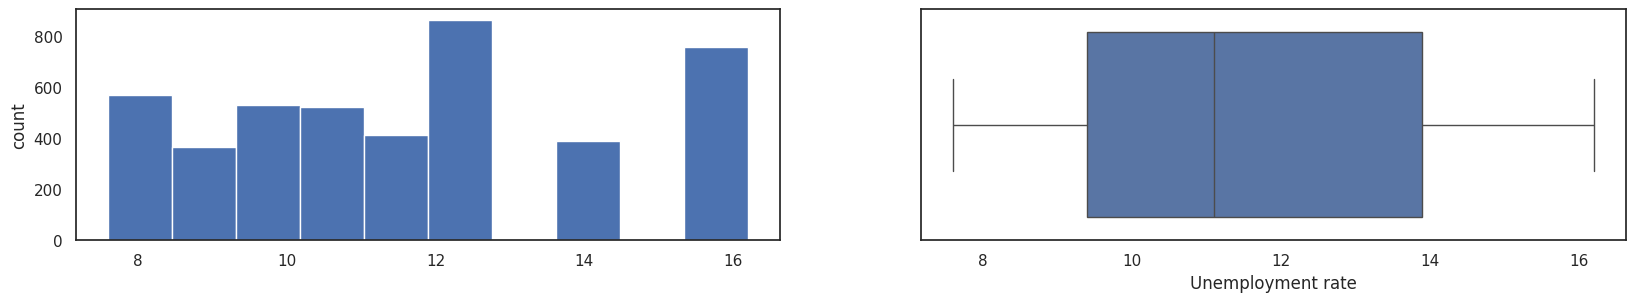

Inflation rate

Média : 1.23
Mediana : 1.4
Variância : 1.91
Desvio padrão : 1.38
Min : -0.8
Max : 3.7
Intervalo:  4.5
Amostras únicas : 9
Amostras faltando : 0
Q1 : 0.3
Q3 : 2.6
IQR : 2.3
Limite inferior : -3.15
Limite superior : 6.05
Obliquidade : 0.25
Curtose : -1.04


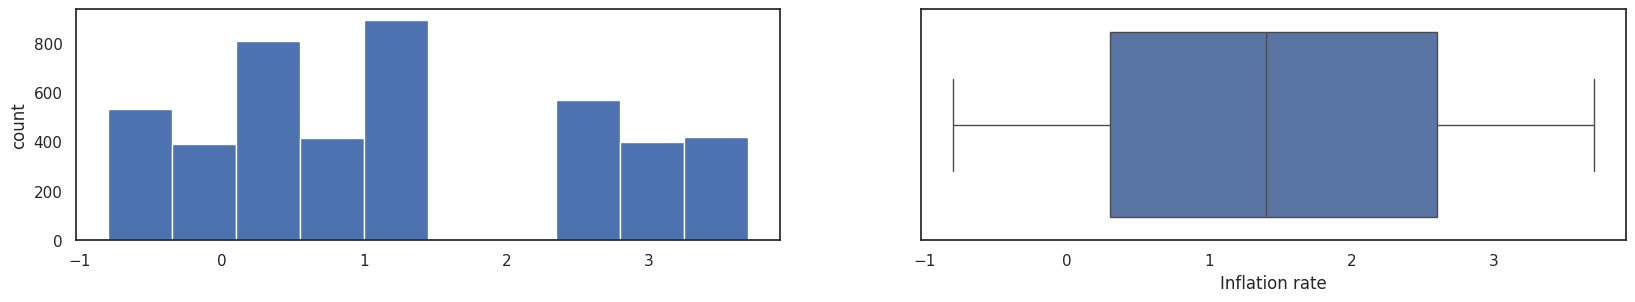

GDP

Média : 0.0
Mediana : 0.32
Variância : 5.15
Desvio padrão : 2.27
Min : -4.06
Max : 3.51
Intervalo:  7.57
Amostras únicas : 10
Amostras faltando : 0
Q1 : -1.7
Q3 : 1.79
IQR : 3.49
Limite inferior : -6.94
Limite superior : 7.02
Obliquidade : -0.39
Curtose : -1.0


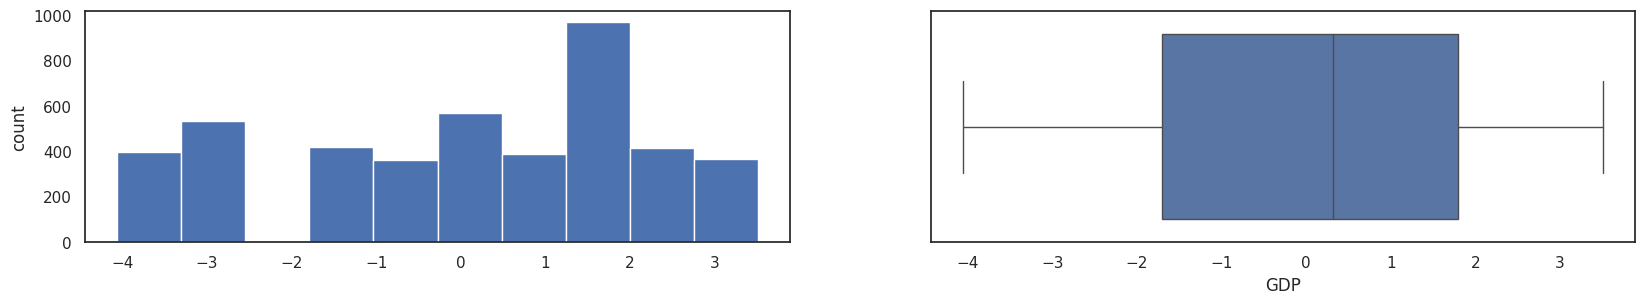

In [191]:
for col in numerical_data:
    
    # Atributo
    print(col, end="\n\n")

    # Estatísticas descritivas
    print('Média :', round(data[col].mean(), 2))
    print('Mediana :', round(data[col].median(), 2))
    print('Variância :', round(data[col].var(), 2))
    print('Desvio padrão :', round(data[col].std(), 2))
    print('Min :', round(data[col].min(), 2))
    print('Max :', round(data[col].max(), 2))
    print('Intervalo: ', round(data[col].max() - data[col].min(), 2))
    print('Amostras únicas :', data[col].nunique())
    print('Amostras faltando :', data[col].isnull().sum())
    print('Q1 :', round(data[col].quantile(0.25), 2))
    print('Q3 :', round(data[col].quantile(0.75), 2))
    print('IQR :', round(data[col].quantile(0.75) - data[col].quantile(0.25), 2))
    print('Limite inferior :', round(data[col].quantile(0.25) - 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Limite superior :', round(data[col].quantile(0.75) + 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Obliquidade :', round(data[col].skew(), 2))
    print('Curtose :', round(data[col].kurt(), 2))

    # Gráficos - referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/
    plt.figure(figsize = (20, 3))
    plt.subplot(1, 2, 1)
    data[col].hist(grid=False)
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Atributos categóricos
Gráficos:
- Histograma: distribuição de frequência (contagem das classes)

Estatística descritiva:
- Moda
- Invervalo
- Variância
- Desvio padrão

#### a. Distribuição de frequência

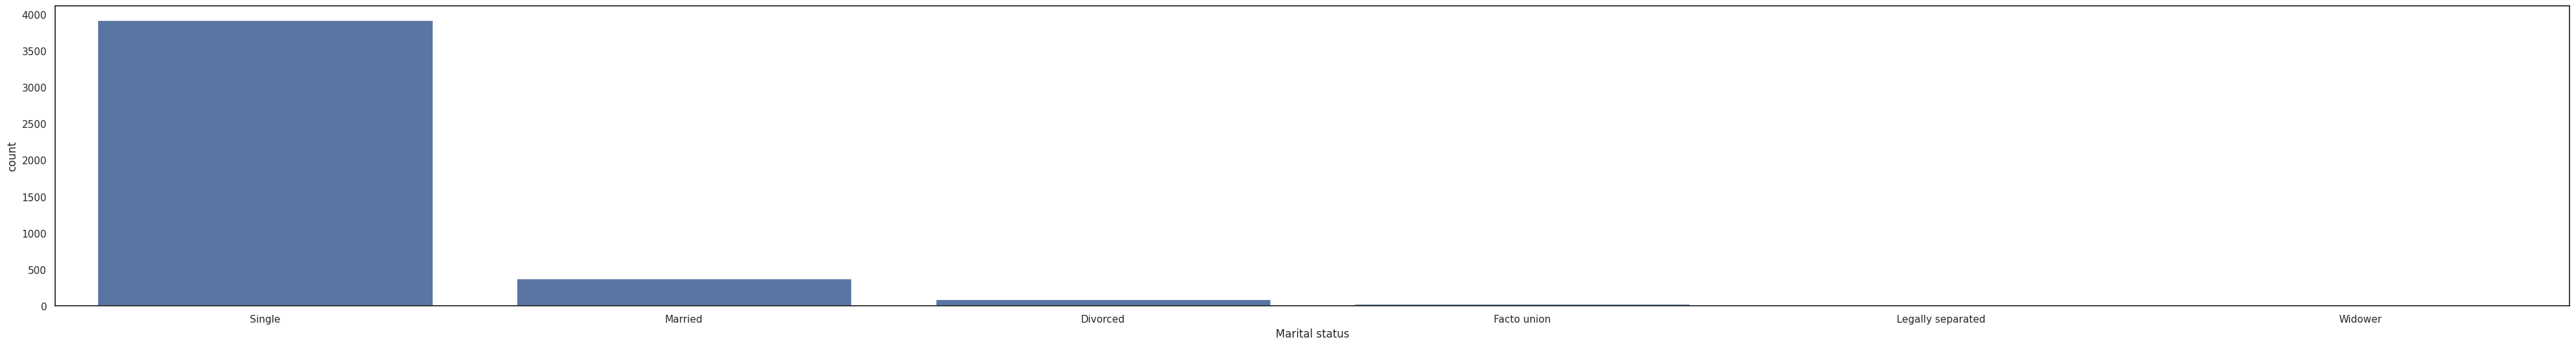

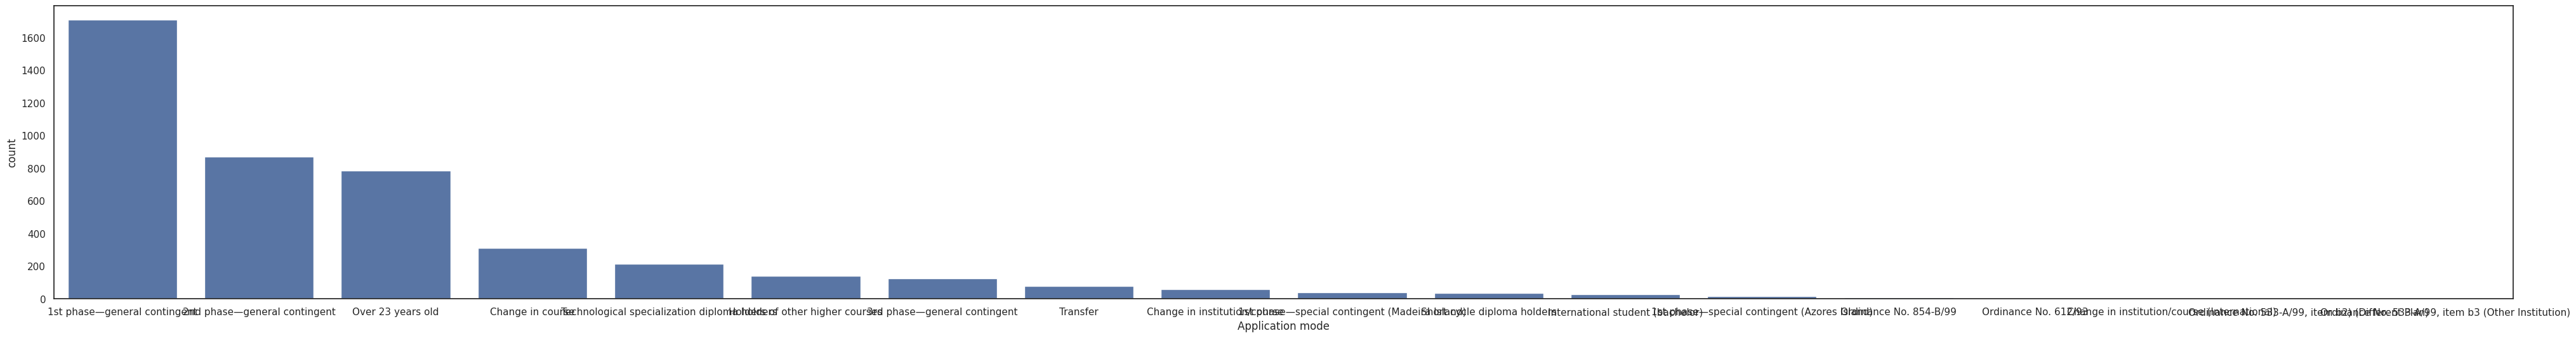

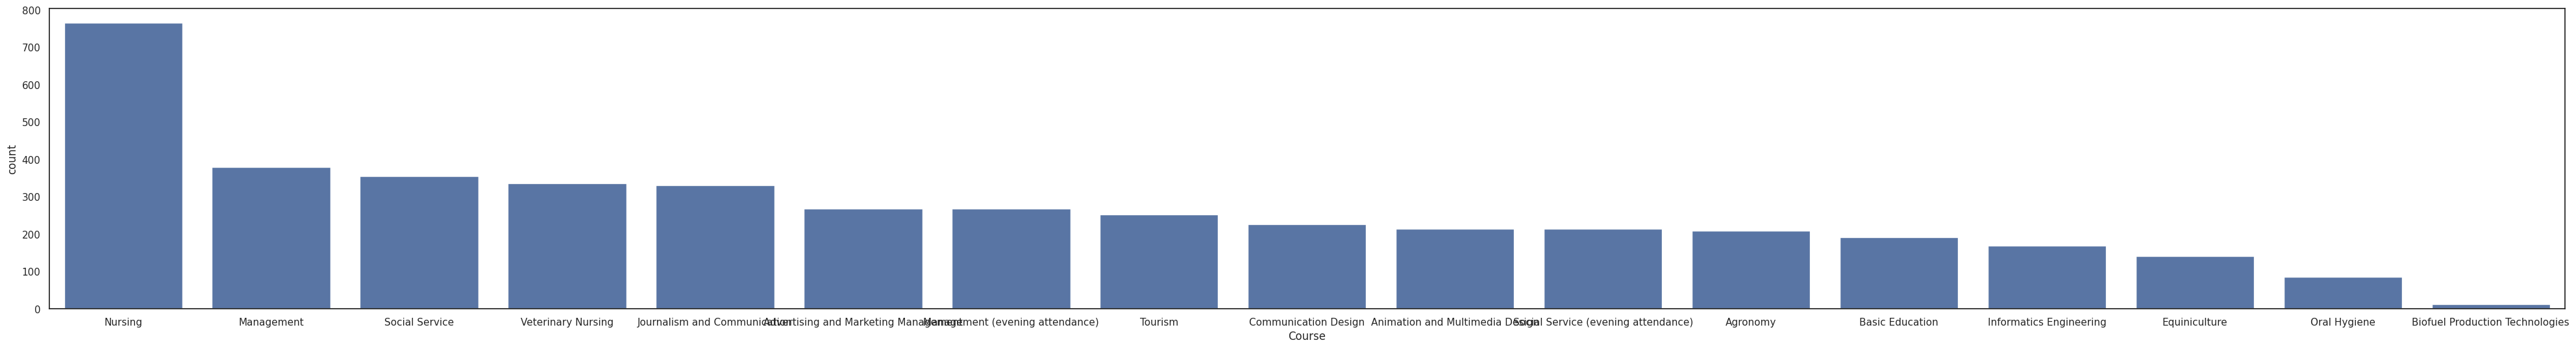

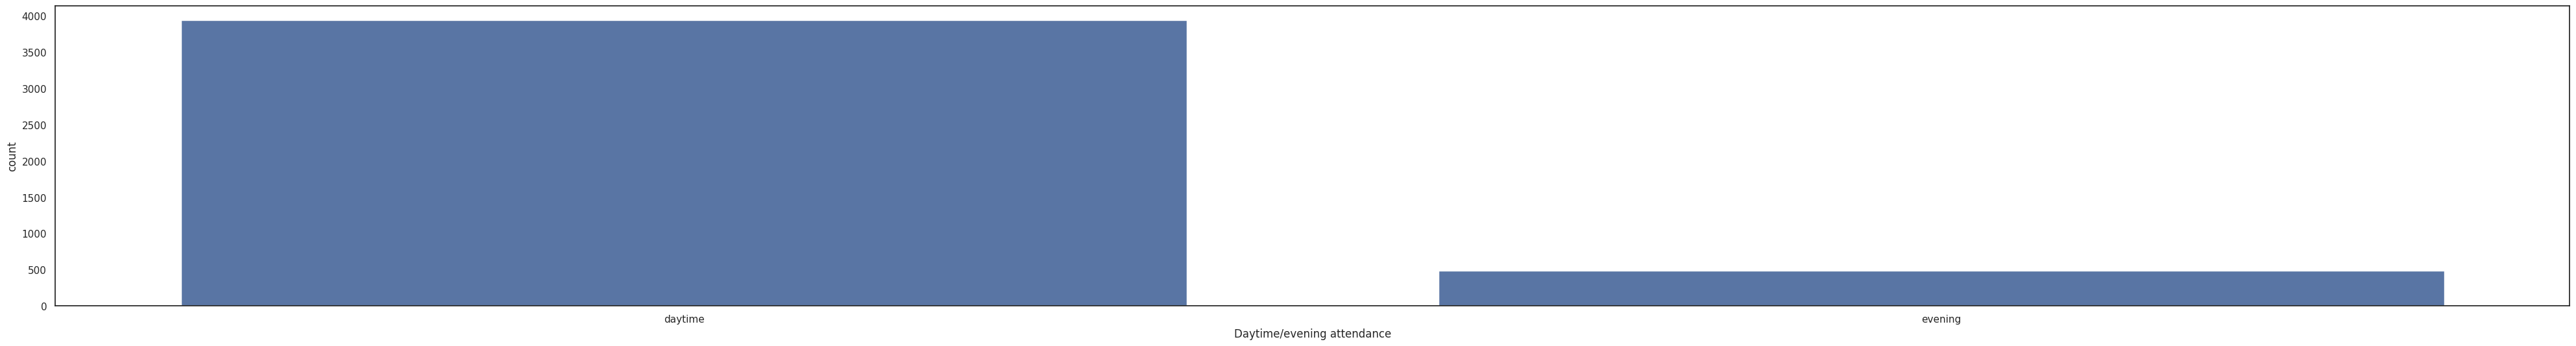

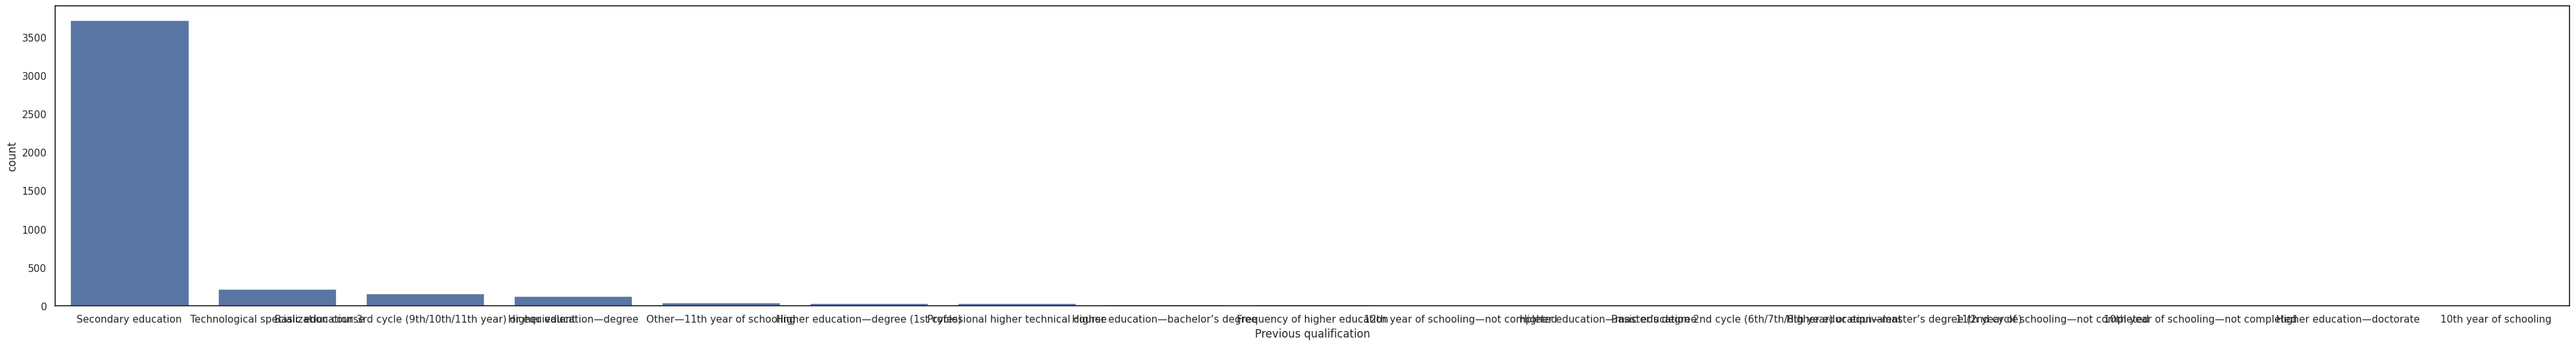

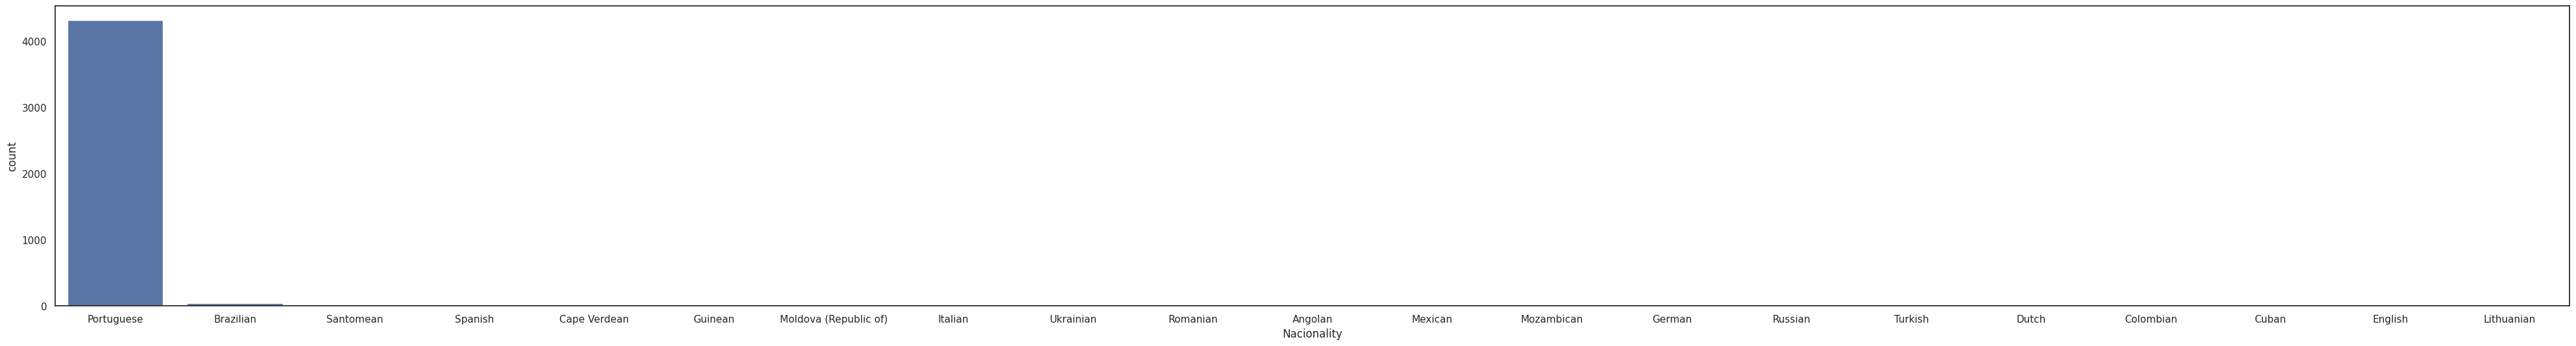

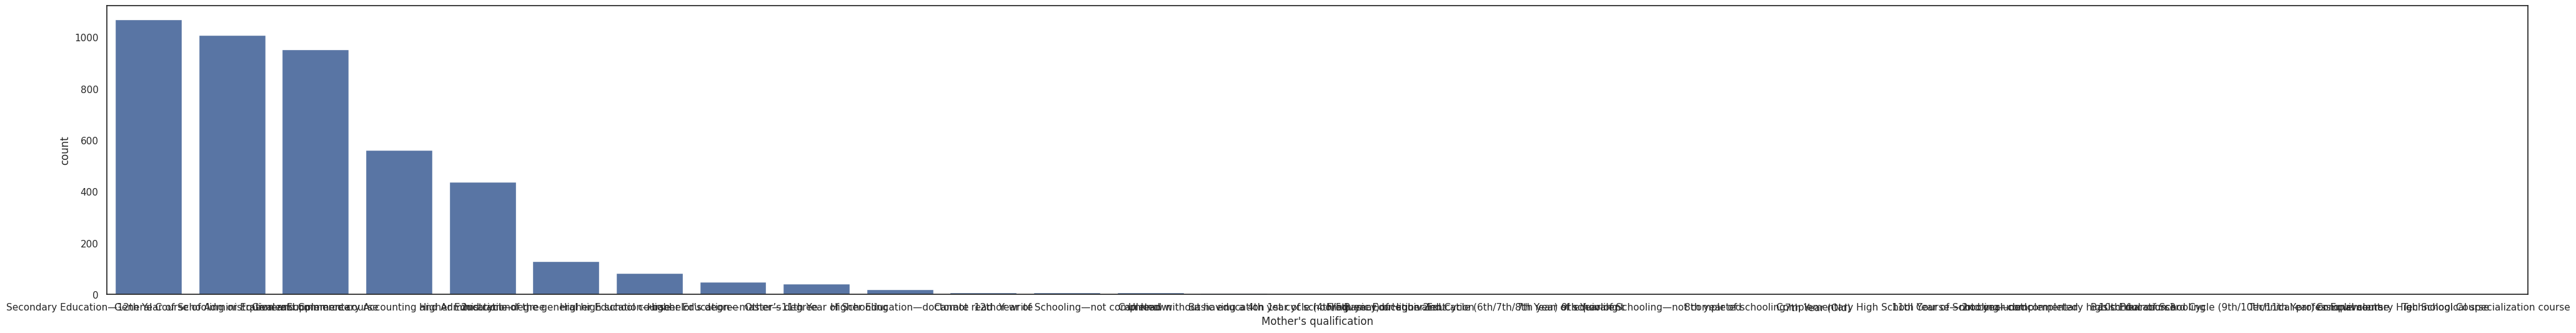

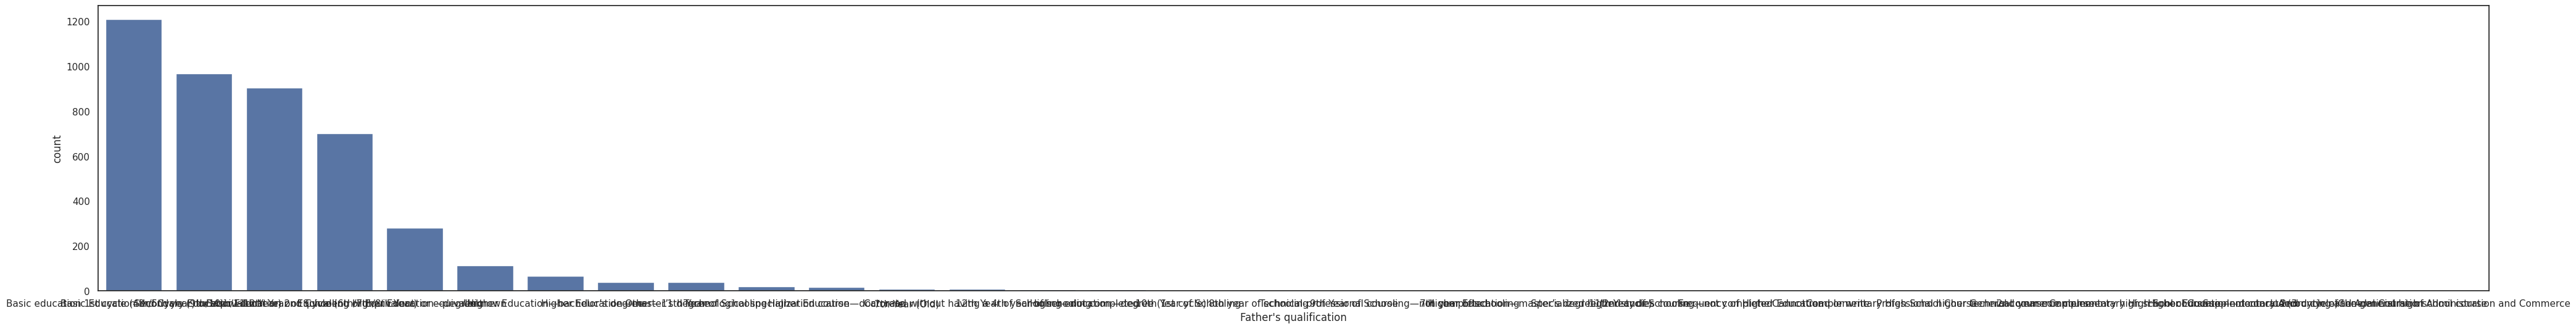

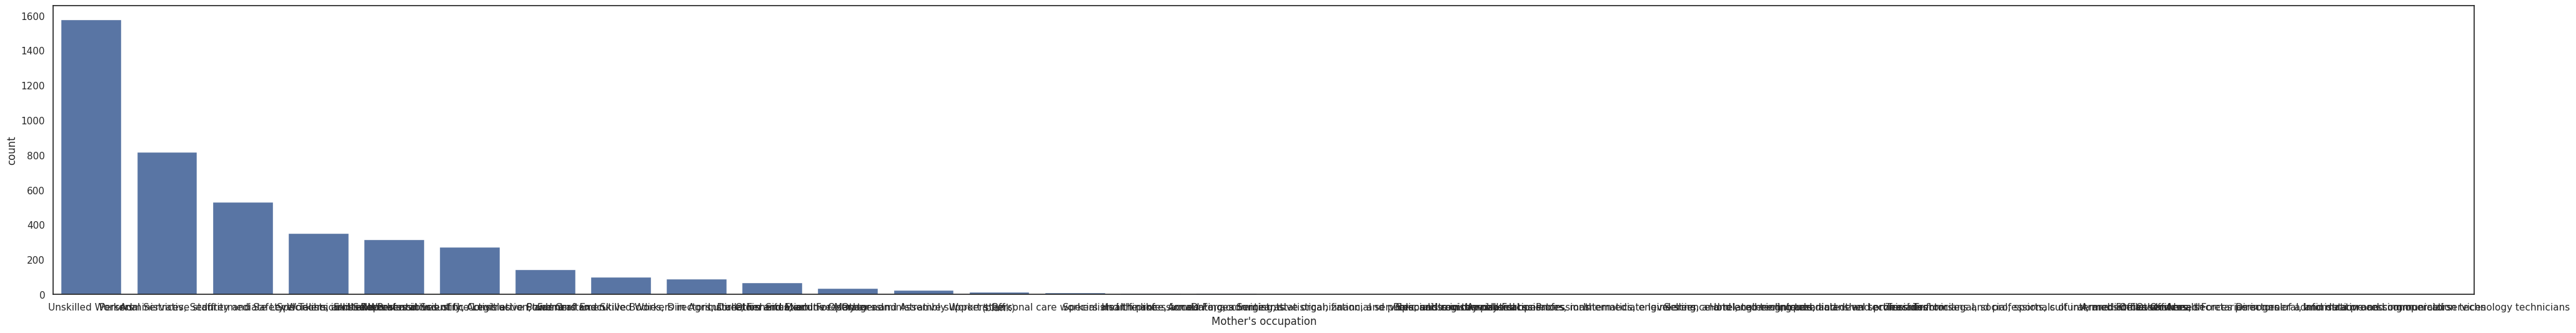

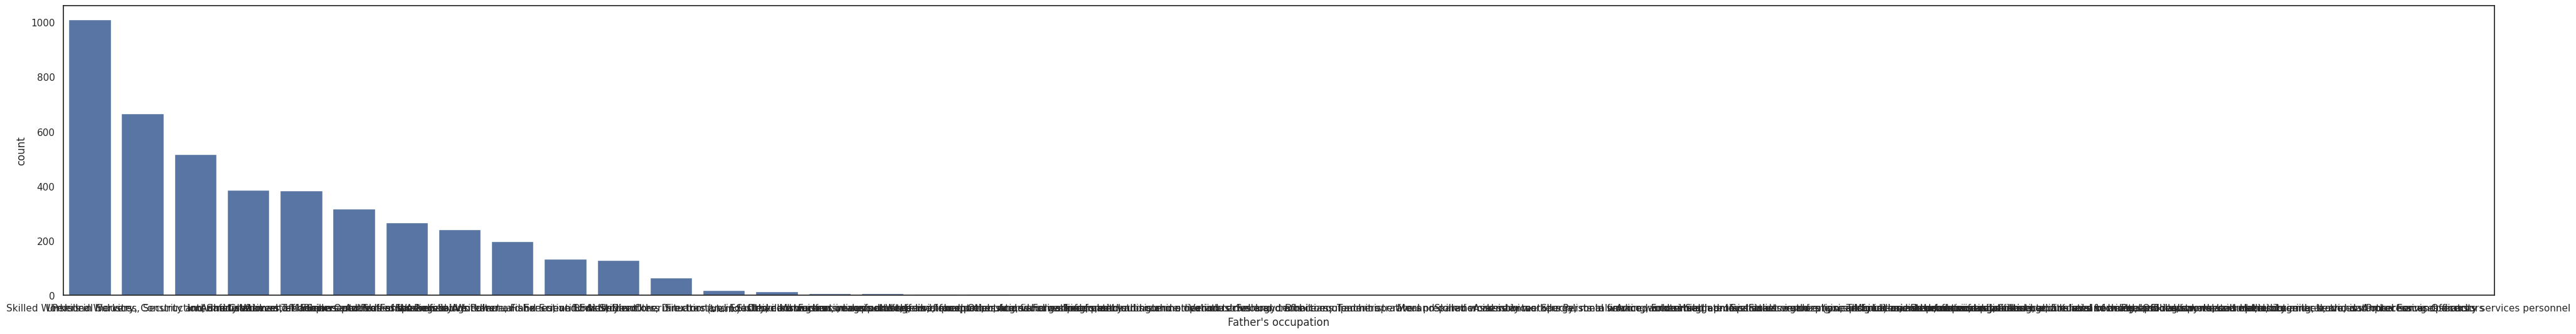

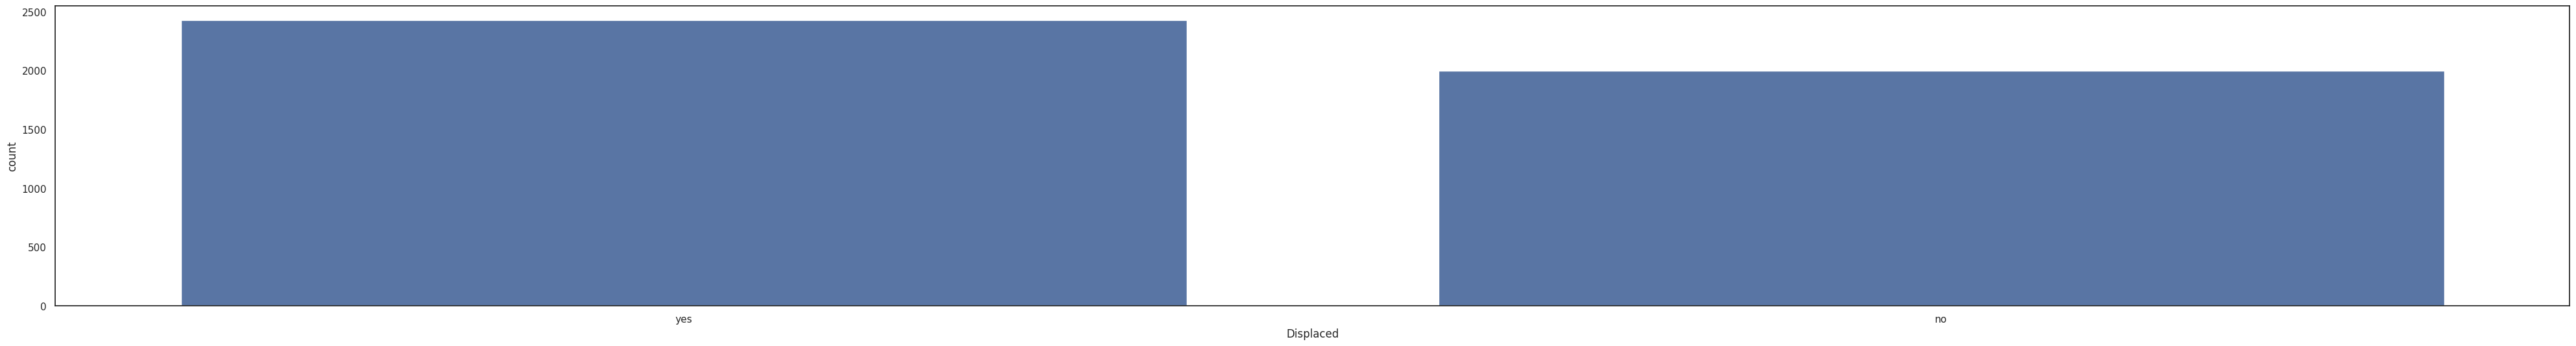

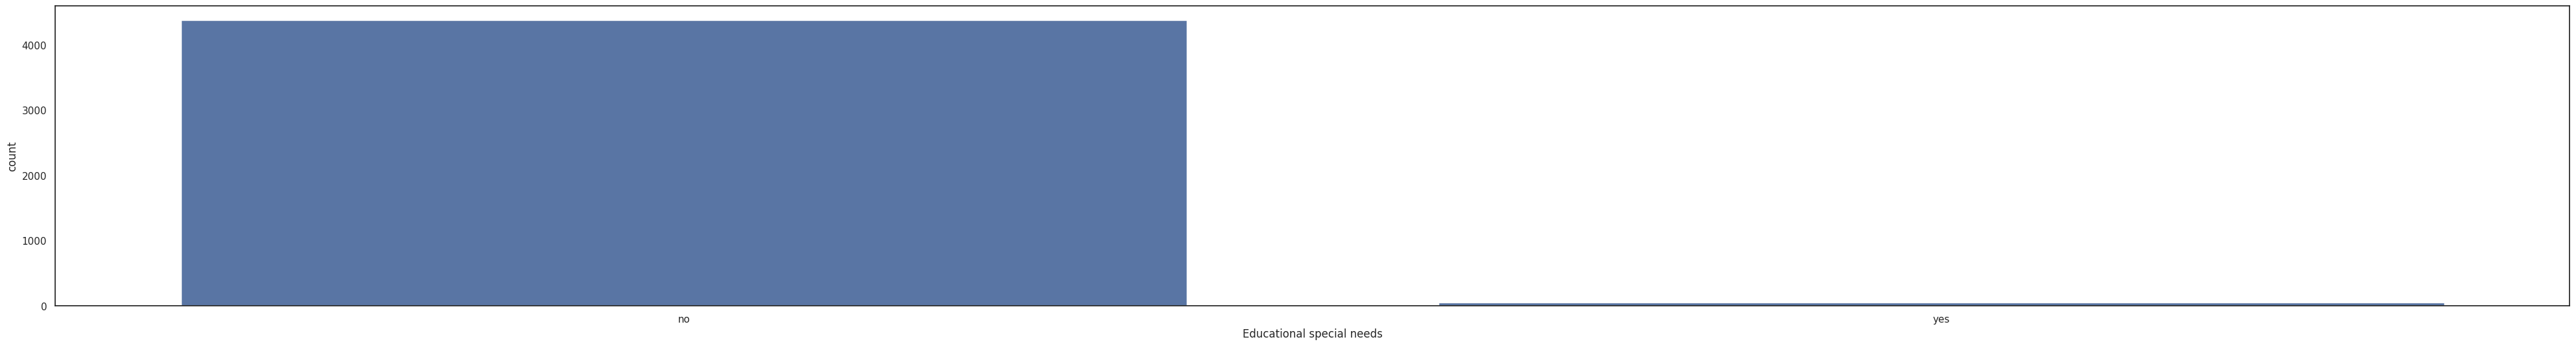

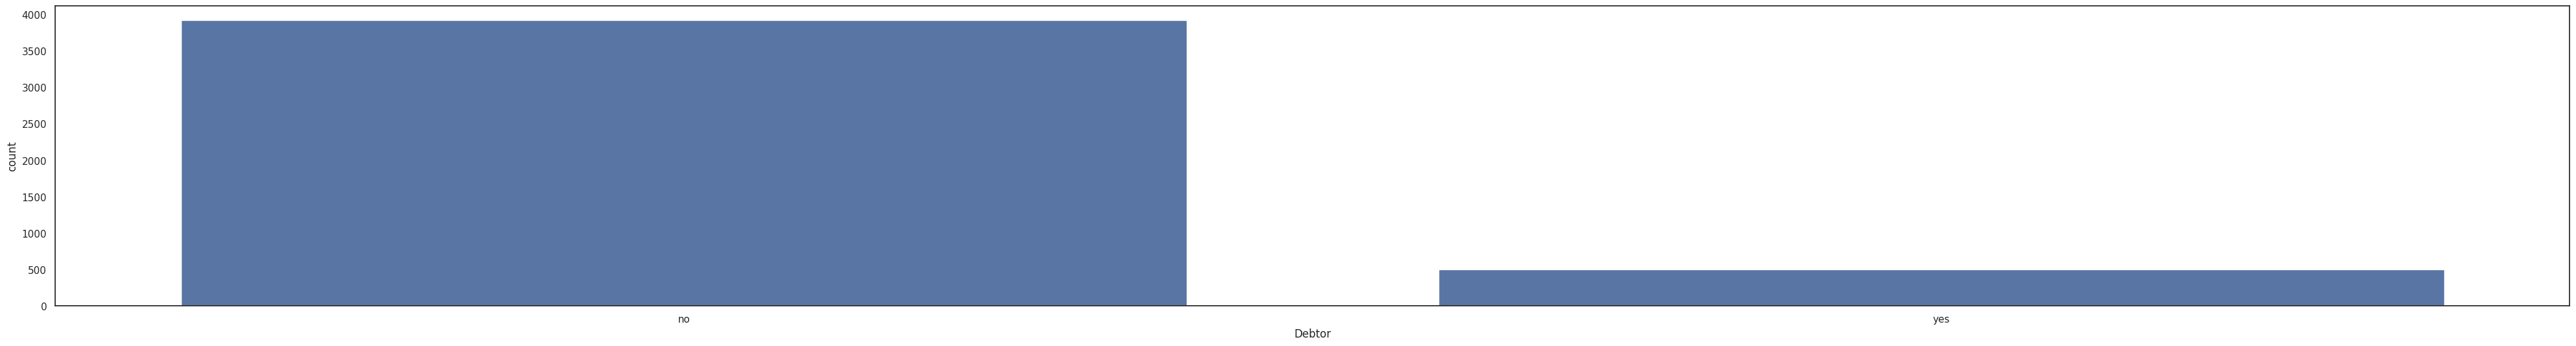

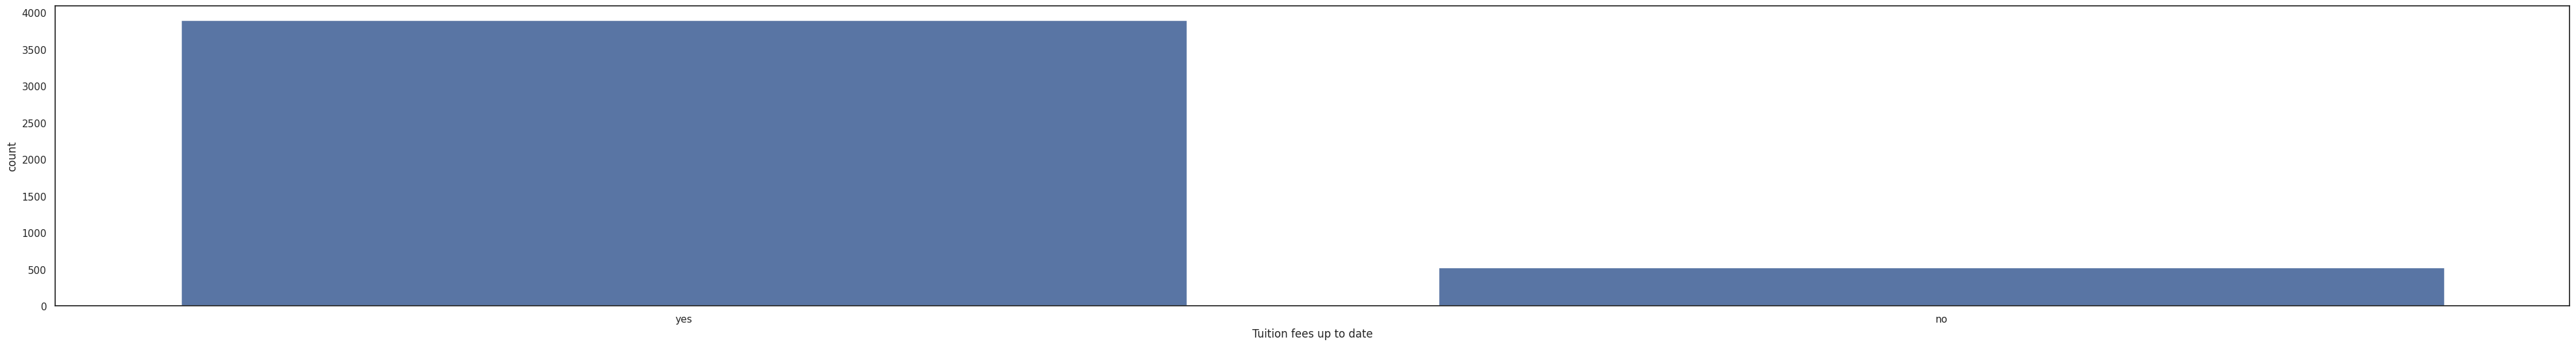

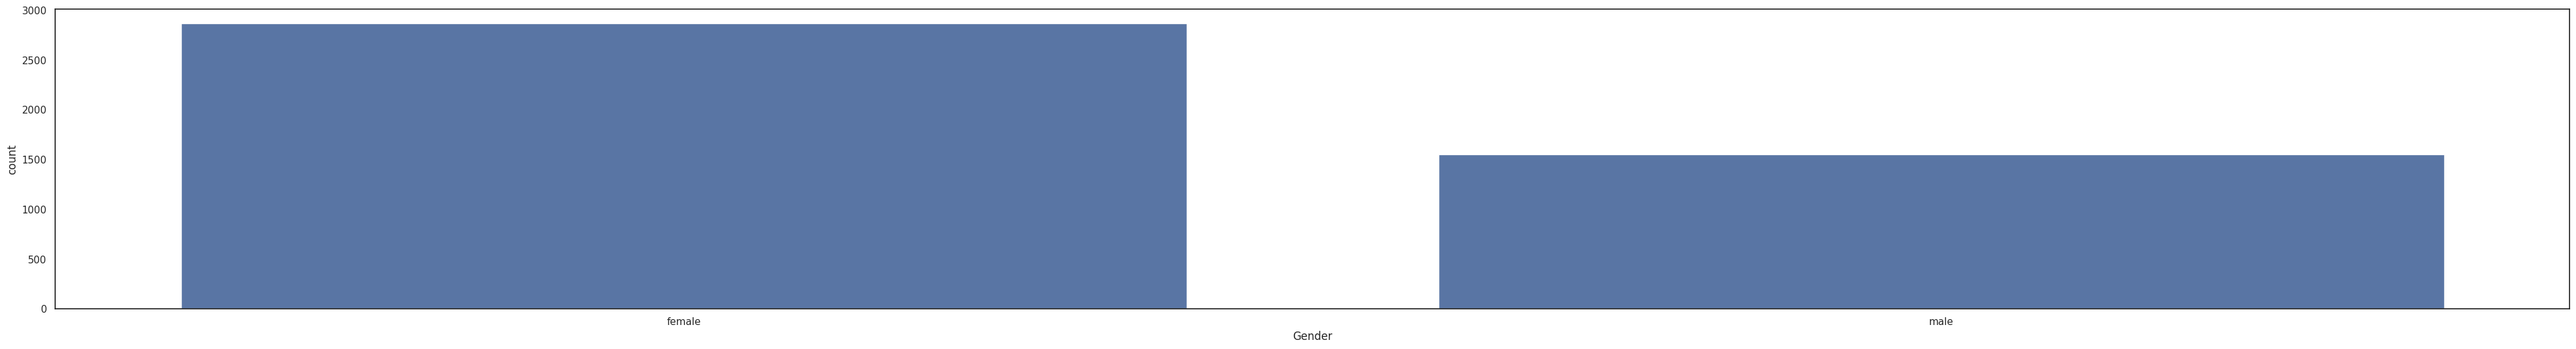

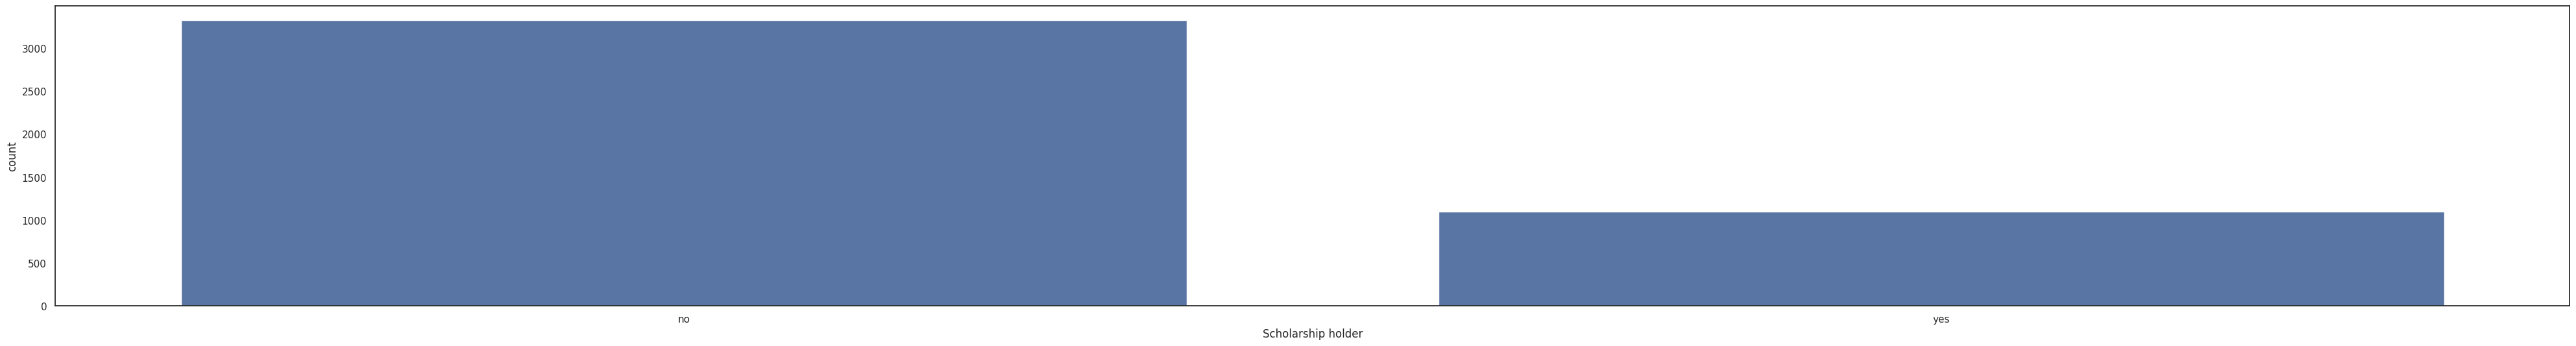

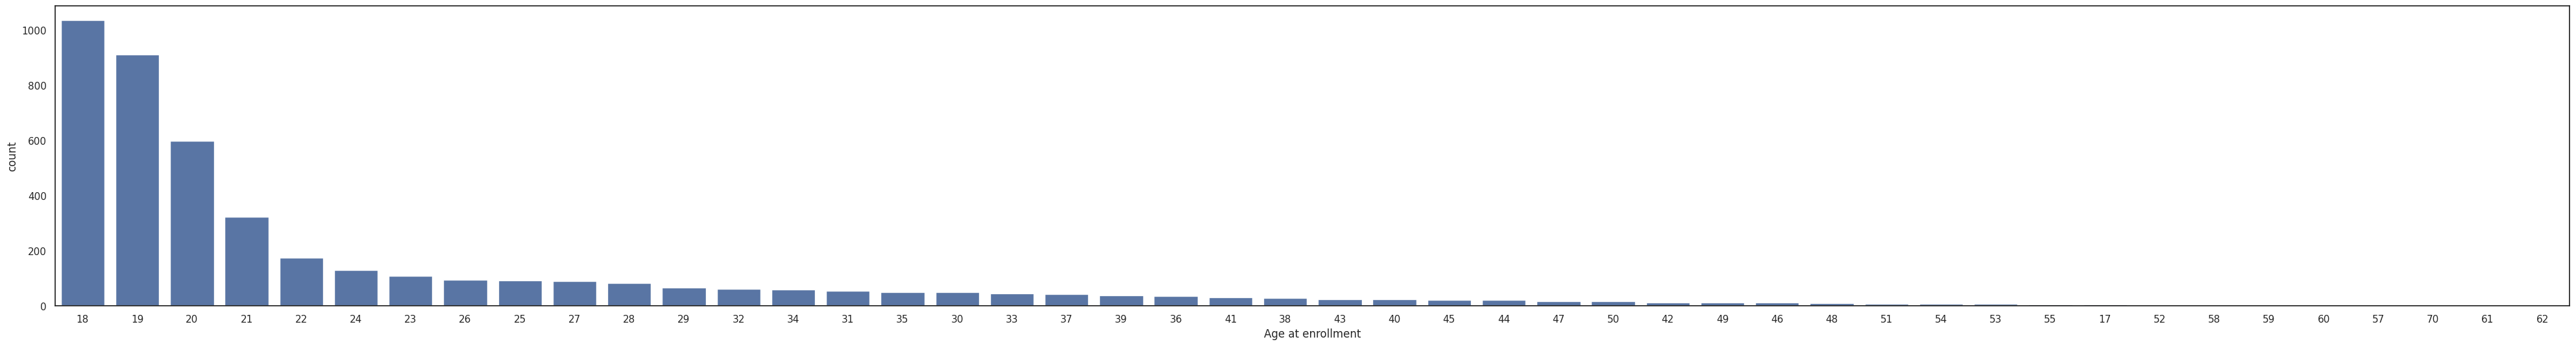

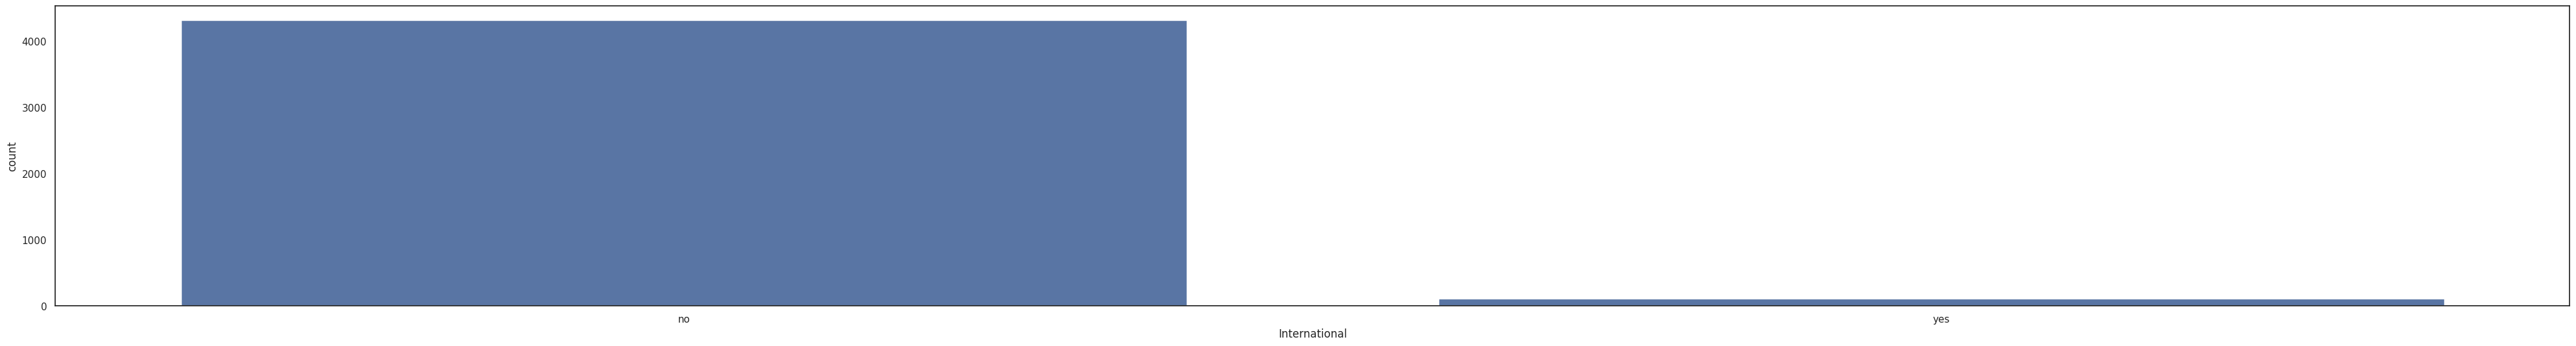

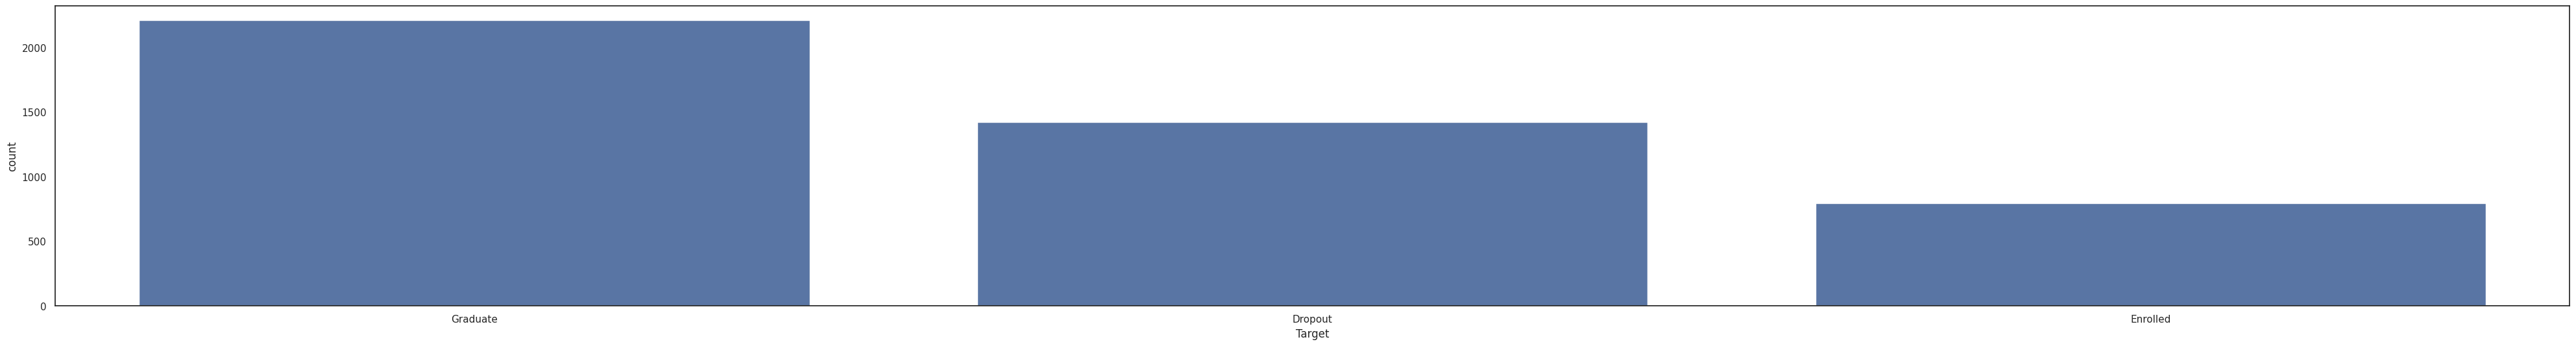

In [192]:
# Referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

for col in categorical_data:
    fig = plt.figure(figsize=(50, 6))

    sns.countplot(x = col, data = data_cat, 
                 order=data_cat[col].value_counts().index)
    
    #palette=['red', 'green', 'blue'], hue='target',

## P4. Quais os padrões e anomalias entre todos os atributos?

- **Análise bivariada** quais as relações entre pares de atributos?

Target        Dropout  Enrolled  Graduate
Nacionality                              
Angolan           1.0       1.0       0.0
Brazilian        14.0       6.0      18.0
Cape Verdean      4.0       1.0       8.0
Colombian         1.0       0.0       0.0
Cuban             0.0       1.0       0.0


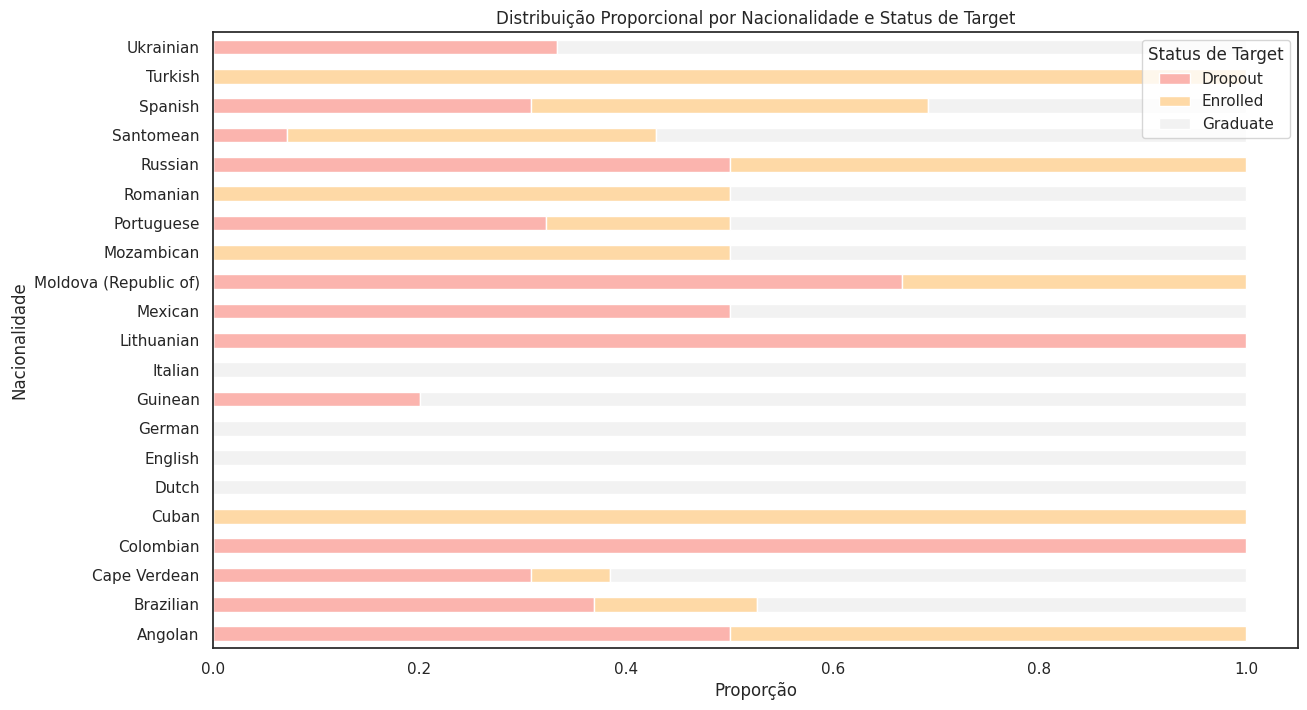

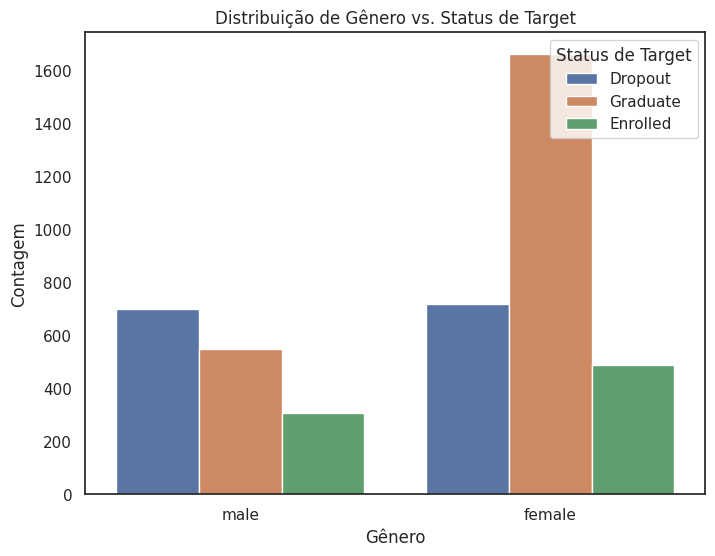

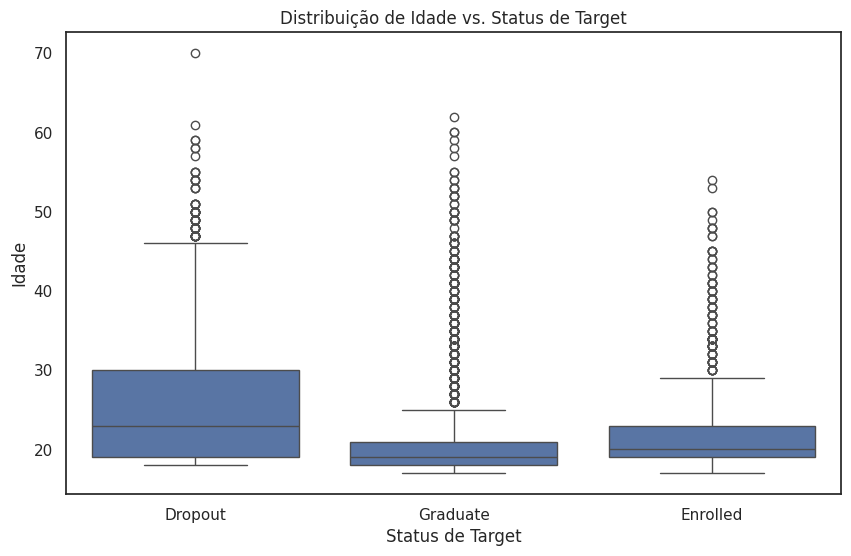

In [193]:
# Agrupando os dados por Nacionalidade e Status de Target
stacked_data = data_cat.groupby(['Nacionality', 'Target']).size().unstack().fillna(0)

# Normalizando os dados para mostrar proporções em vez de contagens absolutas
normalized_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)

print(stacked_data.head())

# Criando o gráfico de barras empilhadas normalizado
normalized_data.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='Pastel1')

plt.title('Distribuição Proporcional por Nacionalidade e Status de Target')
plt.xlabel('Proporção')
plt.ylabel('Nacionalidade')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Gráfico de Distribuição de Gênero vs. Status de Target
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Target', data=data_cat)
plt.title('Distribuição de Gênero vs. Status de Target')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Idade
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cat, x='Target', y='Age at enrollment')
plt.title('Distribuição de Idade vs. Status de Target')
plt.xlabel('Status de Target')
plt.ylabel('Idade')
plt.show()

- **Análise multivariada**: quais as relações entre as variáveis numéricas e categóricas?

Para podermos comparar variáveis numéricas e categóricas, precisamos mapear as strings categóricas para atributos numéricos. Como neste dataset, originalmente, as variáveis categóricas já estão mapeadas em valores numéricos discretos, precisamos apenas mapear o atributo alvo.

In [194]:
# Podemos mudar essas strings para valores int
# Label encoding
data['Target'] = data['Target'].map({
    'Dropout':0,
    'Enrolled':1,
    'Graduate':2
})

print(data["Target"].unique())

[0 2 1]


Com isto, avaliamos quais fatores influenciam diretamente a desistência dos alunos através do método de correlação de Pearson. Queremos visualizar a correlação entre os atributos. Para isto, criamos uma matriz de correlação diagonal.

In [195]:
attribute_corr = data.corr(method = 'pearson') # Gera uma matriz de correlação e mostra apenas as correlações entre o Target e outras variáveis

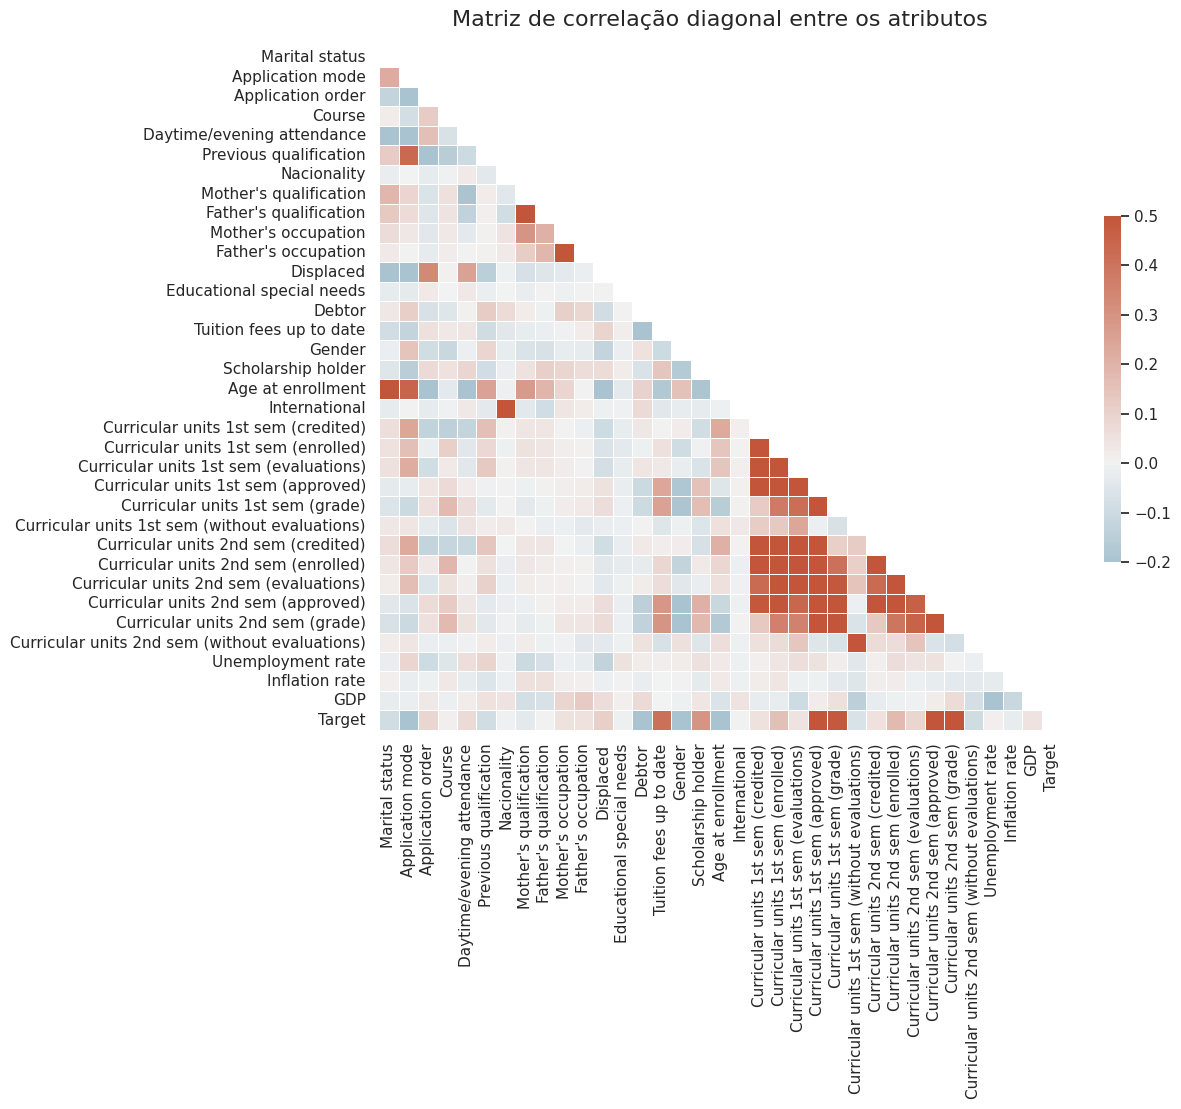

In [196]:
# Plotting a diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(attribute_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
diag_heatmap = sns.heatmap(attribute_corr, mask=mask, cmap=cmap, vmax=.5, vmin=-.2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

diag_heatmap.set_title('Matriz de correlação diagonal entre os atributos', fontdict={'fontsize':16}, pad=16);

Para um modelo preditivo, é interessante analisar a correlação entre as variáveis independentes com a variável dependente. Isto pode nos ajudar a escolhermos os melhores atributos preditivos para treinar nosso modelo. Para isto, criamos uma visualização da correlação entre todos os atributos com o atributo alvo 'Target', de forma descendente.

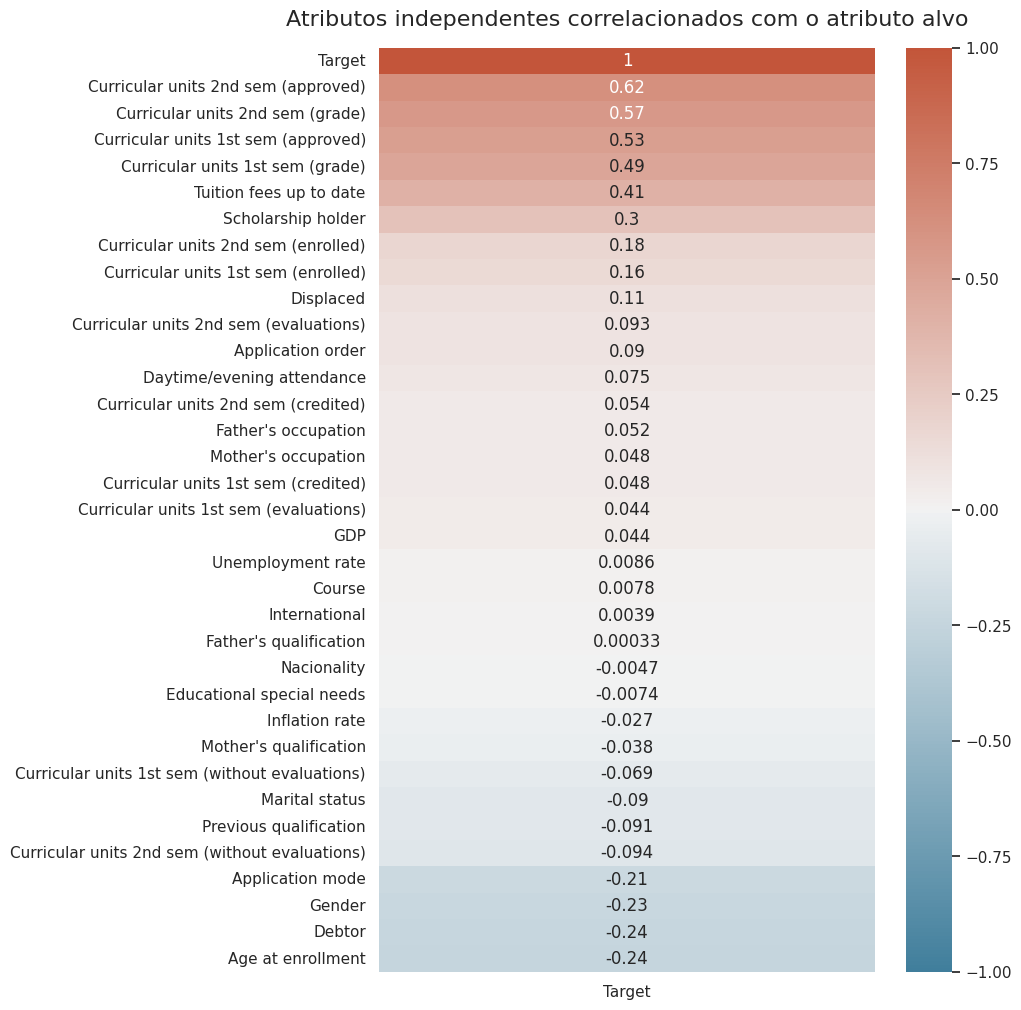

In [197]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

attr_corr_target = data.corr()[['Target']].sort_values(by='Target', ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16);

In [198]:
# Filtra atributos com correlação com Target > 0.25
strong_corr = attr_corr_target[attr_corr_target.gt(0.25).any(axis=1)]
strong_corr.index.tolist()
data[strong_corr.index.tolist()].head()

,Target,Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Tuition fees up to date,Scholarship holder
0,0,0,0.000000,0,0.000000,1,0
1,2,6,13.666667,6,14.000000,0,0
2,0,0,0.000000,0,0.000000,0,0
3,2,5,12.400000,6,13.428571,1,0
4,2,6,13.000000,5,12.333333,1,0


Vários dados não seguem nenhum padrão específico por serem encodings.
Se optou então por seguir com Pearson, que tem um melhor aproveitamento em gráficos com distribuições semelhantes à uma distribuição normal e correlações lineares

Podemos interpretar as correlações da seguinte maneira:

**Fortes:**
* Curricular units 2nd sem (approved)	0.624157
* Curricular units 2nd sem (grade)	0.566827
* Curricular units 1st sem (approved)	0.529123
* Curricular units 1st sem (grade)	0.485207
* Tuition fees up to date	0.409827
* Scholarship holder	0.297595

**Moderadas:**
* Curricular units 2nd sem (enrolled)	0.175847
* Curricular units 1st sem (enrolled)	0.155974
* Displaced	0.113986
* Application mode	-0.212025
* Gender	-0.229270
* Debtor	-0.240999
* Age	-0.243438

**Fracas:**
* Curricular units 2nd sem (evaluations)	0.092721
* Application order	0.089791
* Daytime/evening attendance	0.075107
* Curricular units 2nd sem (credited)	0.054004
* Father's occupation	0.051702
* Mother's occupation	0.048424
* Curricular units 1st sem (credited)	0.048150
* Curricular units 1st sem (evaluations)	0.044362
* GDP	0.044135
* Inflation rate	-0.026874
* Mother's qualification	-0.038346
* Curricular units 1st sem (without evaluations)	-0.068702
* Marital status	-0.089804
* Previous qualification	-0.091365
* Curricular units 2nd sem (without evaluations)	-0.094028

**Sem correlação:**
* Unemployment rate	0.008627
* Course	0.007841
* International	0.003934
* Father's qualification	0.000329
* Nationality	-0.004740
* Educational special needs	-0.007353


Podemos remover todas as colunas de variáveis com correlação "fraca" e "sem correlação" por considerarmos que estas não irão contribuir positivamente para o treinamento do modelo.

Visto que o modelo preditivo será feito para estudantes da UFRGS, é importante notar que algumas variáveis relacionadas ao pagamento pelo ensino não fazem sentido, porém, dado que algumas dessas variáveis possuem correlações importantes, manteremos ela no treinamento do modelo e posteriormente as consideraremos valores para estas pertinentes a estudantes que não têm nenhuma dívida ou não precisam pagar nenhum valor.


# Atributos categóricos

| **Atributo**  | **Categorias** | **Descrição** |
|---|---|---|
| **Application mode** | 1: 1st phase—general contingent<br>2: Ordinance No. 612/93<br>3: 1st phase—special contingent (Azores Island)<br>4: Holders of other higher courses<br>5: Ordinance No. 854-B/99<br>6: International student (bachelor)<br>7: 1st phase—special contingent (Madeira Island)<br>8: 2nd phase—general contingent<br>9: 3rd phase—general contingent<br>10: Ordinance No. 533-A/99, item b2) (Different Plan)<br>11: Ordinance No. 533-A/99, item b3 (Other Institution)<br>12: Over 23 years old<br>13: Transfer<br>14: Change in course<br>15: Technological specialization diploma holders<br>16: Change in institution/course<br>17: Short cycle diploma holders<br>18: Change in institution/course (International) | Modo de aplicação para entrada na universidade. |
| **Displaced** | 0: Não é displaced<br>1: É displaced | Indica se uma pessoa foi forçada a abandonar sua casa ou local de nascimento devido a conflitos, violência, violação de direitos humanos, etc. |
| **Debtor** | 0: Não é devedor<br>1: É devedor | Indica se a pessoa estudante é devedora ou não. *detalhar, devedora de que*                                                                                     |
| **Tuition fees up to date** | 0: Não Possui o pagamento da universidade em dia<br>1: Possui o pagamento da universidade em dia  |  |
| **Gender** | 0: Feminino<br>1: Masculino | |
| **Scholarship holder** | 0: Não possui bolsa<br>1: Possui bolsa | |


# Atributos numéricos



|**Atributo**|**Tipo**|**Descrição**|
|---|---|---|
| **Age** | Discreto | Idade que entrou na universidade |
| **Curricular units 1st sem (enrolled)** | Discreto | em quantas cadeiras o aluno se inscreveu no primeiro semestre? |
| **Curricular units 1st sem (approved)** | Discreto | em quantas cadeiras o aluno foi aprovado no primeiro semestre? |
| **Curricular units 1st sem (grade)** | Discreto | a nota do aluno referente às cadeiras do primeiro semestre |
| **Curricular units 2nd sem (enrolled)** | Discreto | em quantas cadeiras o aluno se inscreveu no segundo semestre? |
| **Curricular units 2nd sem (approved)** | Discreto | em quantas cadeiras o aluno foi aprovado no segundo semestre? |
| **Curricular units 2nd sem (grade)** | Discreto | a nota do aluno referente às cadeiras do segundo semestre |